<a href="https://colab.research.google.com/github/azzindani/02_Machine_Learning/blob/main/Insurance_Charge_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Version 20240815

## 00 Importing Modules & Mounting Drive

In [1]:
!pip install ydata-profiling

import pathlib
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import os
import numpy as np
import pandas as pd
import sklearn
import pickle
import plotly.express as px
import plotly.graph_objects as go
import xgboost as xgb

from scipy import stats as sm
from IPython.display import Image
from graphviz import Source
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, r2_score, accuracy_score, average_precision_score, f1_score, precision_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile
from ydata_profiling import ProfileReport
from tabulate import tabulate
from time import sleep

%matplotlib inline

In [2]:
'''from google.colab import drive
drive.mount('/content/drive') #'''

"from google.colab import drive\ndrive.mount('/content/drive') #"

In [3]:
'''MAIN_PATH = str(pathlib.Path().resolve())
WORK_PATH = MAIN_PATH + '/drive/MyDrive/Workspace'
SOURCE_PATH = WORK_PATH + '/00_Data_Source'
CACHE_PATH = WORK_PATH + '/00_Cache_Data' #'''

"MAIN_PATH = str(pathlib.Path().resolve())\nWORK_PATH = MAIN_PATH + '/drive/MyDrive/Workspace'\nSOURCE_PATH = WORK_PATH + '/00_Data_Source'\nCACHE_PATH = WORK_PATH + '/00_Cache_Data' #"

## 01 Choosing & Importing Dataset

### 01.00 Importing Data from Zipfile

In [4]:
filename = 'Insurance.zip' # replace this

url = 'https://github.com/azzindani/00_Data_Source/raw/main/'+ filename
http_response = urlopen(url)
zipfile = ZipFile(BytesIO(http_response.read()))
zipfile.extractall() #'''

In [5]:
os.listdir()

['.config', 'insurance_dataset.csv', 'sample_data']

In [6]:
df = pd.read_csv(os.listdir()[1], encoding = 'ISO-8859-1')#, sep = ';')
df.shape #'''

(1000000, 12)

### 01.01 Importing Main Data

In [7]:
'''filename = 'Indonesia_Earthquake.csv' # replace this

url = 'https://github.com/azzindani/00_Data_Source/raw/main/'+ filename
df = pd.read_csv(url, encoding = 'ISO-8859-1')#, sep = '\t')
df.shape #'''

"filename = 'Indonesia_Earthquake.csv' # replace this\n\nurl = 'https://github.com/azzindani/00_Data_Source/raw/main/'+ filename\ndf = pd.read_csv(url, encoding = 'ISO-8859-1')#, sep = '\t')\ndf.shape #"

In [8]:
df.nunique()

,0
age,48
gender,2
bmi,3201
children,6
smoker,2
region,4
medical_history,3
family_medical_history,3
exercise_frequency,4
occupation,4


In [9]:
df.head(2)

,age,gender,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level,charges
0,46,male,21.45,5,yes,southeast,Diabetes,NaN,Never,Blue collar,Premium,20460.307669
1,25,female,25.38,2,yes,northwest,Diabetes,High blood pressure,Occasionally,White collar,Premium,20390.899218


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 12 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   age                     1000000 non-null  int64  
 1   gender                  1000000 non-null  object 
 2   bmi                     1000000 non-null  float64
 3   children                1000000 non-null  int64  
 4   smoker                  1000000 non-null  object 
 5   region                  1000000 non-null  object 
 6   medical_history         749238 non-null   object 
 7   family_medical_history  749596 non-null   object 
 8   exercise_frequency      1000000 non-null  object 
 9   occupation              1000000 non-null  object 
 10  coverage_level          1000000 non-null  object 
 11  charges                 1000000 non-null  float64
dtypes: float64(2), int64(2), object(8)
memory usage: 91.6+ MB


### 01.02 Importing Geo Data

In [11]:
'''geo_path = 'https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json' # replace this

gdf = gpd.read_file(geo_path)
gdf.head(2) #'''

"geo_path = 'https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json' # replace this\n\ngdf = gpd.read_file(geo_path)\ngdf.head(2) #"

In [12]:
'''gdf = gdf.rename(columns = {'name' : 'State'})
gdf = gdf[['State', 'geometry']]
gdf.head(2) #'''

"gdf = gdf.rename(columns = {'name' : 'State'})\ngdf = gdf[['State', 'geometry']]\ngdf.head(2) #"

### 01.03 Importing Additional Data (for enrichment)

### 01.04 Dataframe Back Up

In [13]:
df_bu = df.copy()

## 02 Data Structuring

### 02.01 Selecting & Dropping Variables

In [14]:
column_list = [] # fill this

df = df.drop(column_list, axis = 1)
df.head(2) #'''

,age,gender,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level,charges
0,46,male,21.45,5,yes,southeast,Diabetes,NaN,Never,Blue collar,Premium,20460.307669
1,25,female,25.38,2,yes,northwest,Diabetes,High blood pressure,Occasionally,White collar,Premium,20390.899218


### 02.02 Cleaning Text Object

#### 02.02.01 Convert Header to Proper Text

In [15]:
'''for x in df.columns:
  y = x.title()
  df = df.rename(columns = {x : y}) #'''

'for x in df.columns:\n  y = x.title()\n  df = df.rename(columns = {x : y}) #'

#### 02.02.02 Strip Abnormal Spaces

In [16]:
'''for x in df.columns:
  if df[x].dtypes == 'object':
    try:
      df[x] = df[x].str.strip()
    except:
      pass #'''

"for x in df.columns:\n  if df[x].dtypes == 'object':\n    try:\n      df[x] = df[x].str.strip()\n    except:\n      pass #"

#### 02.02.03 Convert Object Content to Proper Text

In [17]:
'''for x in df.columns:
  if df[x].dtypes == 'object':
    for a in df[x].unique():
      b = a.title()
      df[x] = df[x].replace(a, b)
  else:
    pass #'''

"for x in df.columns:\n  if df[x].dtypes == 'object':\n    for a in df[x].unique():\n      b = a.title()\n      df[x] = df[x].replace(a, b)\n  else:\n    pass #"

### 02.03 Coverting Data

#### 02.03.01 Convert to date

In [18]:
df.head(2)

,age,gender,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level,charges
0,46,male,21.45,5,yes,southeast,Diabetes,NaN,Never,Blue collar,Premium,20460.307669
1,25,female,25.38,2,yes,northwest,Diabetes,High blood pressure,Occasionally,White collar,Premium,20390.899218


In [19]:
column_list = ['Activity Period Start Date'] # fill this

for x in column_list:
  try:
    df[x] = pd.to_datetime(df[x])
  except:
    pass #'''

#### 02.03.02 Convert to integer or float

In [20]:
column_list = [] # fill this

for x in column_list:
  df[x] = df[x].astype('int') #'''

#### 02.03.03 Convert to Object (if necessary)

In [21]:
column_list = [] # fill this

for x in column_list:
  df[x] = df[x].astype('str') #'''

#### 02.03.04 Replace 0 to Nan (if necessary)

In [22]:
#df = df.replace(0, np.nan)

#### 02.03.05 Filling 0 to Nan

In [23]:
for column in df.columns:
  if df[column].dtype == 'float64' or df[column].dtype == 'int64':
    df[column] = df[column].fillna(0)
    print(column)
  else:
    pass

age
bmi
children
charges


#### 02.03.06 Dropping Nan

In [24]:
df = df.dropna()

## 03 Data Cleaning

### 03.01 Replacing Variable Component

In [25]:
'''value_dict = {} # fill this

column_name = ''

df[column_name] = df[column_name].replace(value_dict) #'''

"value_dict = {} # fill this\n\ncolumn_name = ''\n\ndf[column_name] = df[column_name].replace(value_dict) #"

### 03.02 Add New Variable

#### 03.02.01 Add by Math Calculation

In [26]:
'''new_var = '' # fill this
obj_var1 = '' # fill this
obj_var2 = '' # fill this

df[new_var] = df[obj_var1] * df [obj_var2] #'''

"new_var = '' # fill this\nobj_var1 = '' # fill this\nobj_var2 = '' # fill this\n\ndf[new_var] = df[obj_var1] * df [obj_var2] #"

#### 03.02.02 Add by Replacing "Other"

In [27]:
'''column_name = '' # fill this

df[column_name].value_counts() #'''

"column_name = '' # fill this\n\ndf[column_name].value_counts() #"

In [28]:
'''value_thres = 1300

replace_list = []

df_dict = df[column_name].value_counts().to_dict()
for i in df_dict:
  if df_dict[i] < value_thres:
    replace_list.append(i)

replace_list #'''

'value_thres = 1300\n\nreplace_list = []\n\ndf_dict = df[column_name].value_counts().to_dict()\nfor i in df_dict:\n  if df_dict[i] < value_thres:\n    replace_list.append(i)\n\nreplace_list #'

In [29]:
'''df[column_name] = df[column_name].copy().replace(to_replace = replace_list, value = 'Other') #'''

"df[column_name] = df[column_name].copy().replace(to_replace = replace_list, value = 'Other') #"

### 03.03 Inaccuracies

In [30]:
column_list = [] # fill this

for x in column_list:
  try:
    df[x] = df[x].replace('0', np.nan)
    df = df.dropna()
  except:
    pass

### 03.04 Handling

##### Data Distribution Check (Before)

In [31]:
df.head(2)

,age,gender,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level,charges
1,25,female,25.38,2,yes,northwest,Diabetes,High blood pressure,Occasionally,White collar,Premium,20390.899218
4,49,male,38.21,3,yes,northwest,Diabetes,High blood pressure,Rarely,White collar,Standard,19268.309838


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 561672 entries, 1 to 999999
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   age                     561672 non-null  int64  
 1   gender                  561672 non-null  object 
 2   bmi                     561672 non-null  float64
 3   children                561672 non-null  int64  
 4   smoker                  561672 non-null  object 
 5   region                  561672 non-null  object 
 6   medical_history         561672 non-null  object 
 7   family_medical_history  561672 non-null  object 
 8   exercise_frequency      561672 non-null  object 
 9   occupation              561672 non-null  object 
 10  coverage_level          561672 non-null  object 
 11  charges                 561672 non-null  float64
dtypes: float64(2), int64(2), object(8)
memory usage: 55.7+ MB


In [33]:
'''x = 'current_month_debit' # replace this
y = 'current_month_balance' # replace this
color = 'occupation' # replace this

fig = px.histogram(
  df,
  x = x,
  y = y,
  color = color,
  marginal = 'box',
  hover_data = df.columns
)

fig.show() #'''

"x = 'current_month_debit' # replace this\ny = 'current_month_balance' # replace this\ncolor = 'occupation' # replace this\n\nfig = px.histogram(\n  df,\n  x = x,\n  y = y,\n  color = color,\n  marginal = 'box',\n  hover_data = df.columns\n)\n\nfig.show() #"

In [34]:
'''x = 'current_month_debit' # replace this
y = 'current_month_balance' # replace this
color = 'occupation' # replace this

fig = px.scatter(
  df,
  x = x,
  y = y,
  color = color,
  marginal_x = 'histogram',
  marginal_y = 'box',
  hover_data = df.columns
)

fig.show() #'''

"x = 'current_month_debit' # replace this\ny = 'current_month_balance' # replace this\ncolor = 'occupation' # replace this\n\nfig = px.scatter(\n  df,\n  x = x,\n  y = y,\n  color = color,\n  marginal_x = 'histogram',\n  marginal_y = 'box',\n  hover_data = df.columns\n)\n\nfig.show() #"

#### 03.04.01 Using IQR (Inter Quantile Range)

In [35]:
def iqr_thres(dataframe, column, th1 = 0.25, th3 = 0.75):
  quartile1 = dataframe[column].quantile(th1)
  quartile3 = dataframe[column].quantile(th3)
  iqr = quartile3 - quartile1
  upper_limit = quartile3 + 1.5 * iqr
  lower_limit = quartile1 - 1.5 * iqr

  return lower_limit, upper_limit

In [36]:
def check_outliers_iqr(dataframe, column):
  lower_limit, upper_limit = iqr_thres(dataframe, column)
  if dataframe[(dataframe[column] > upper_limit) | (dataframe[column] < lower_limit)].any(axis = None):
    return True
  else:
    return False

In [37]:
def replace_iqr(dataframe, columns, th1 = 0.25, th3 = 0.75, replace = False):
  data = []

  for column in columns:
    if dataframe[column].dtypes == 'int64' or dataframe[column].dtypes == 'float64':
      if column != 'Outcome':
        outliers_ = check_outliers_iqr(dataframe, column)
        count = None
        lower_limit, upper_limit = iqr_thres(dataframe, column, th1, th3)

        if outliers_:
          count = dataframe[(dataframe[column] > upper_limit) | (dataframe[column] < lower_limit)][column].count()
          if replace:
            if lower_limit < 0:
              dataframe.loc[(dataframe[column] > upper_limit), column] = np.nan
            else:
              dataframe.loc[(dataframe[column] < lower_limit), column] = np.nan
              dataframe.loc[(dataframe[column] > upper_limit), column] = np.nan
        outliers_status = check_outliers_iqr(dataframe, column)
        data.append([outliers_, outliers_status, count, column, lower_limit, upper_limit ])

  table = tabulate(data, headers = ['Outliers (Previously)', 'Outliers', 'Count', 'Column', 'Lower Limit', 'Upper Limit'], tablefmt = 'rst', numalign = 'right')
  print('Removing Outliers using IQR')
  print(table)

In [38]:
column_list = [] # fill this

replace_iqr(
  dataframe = df,
  columns = column_list,
  replace = True
)
df = df.dropna()#'''

Removing Outliers using IQR
=======================  ==========  =======  ========  =============  =============
Outliers (Previously)    Outliers    Count    Column    Lower Limit    Upper Limit
=======================  ==========  =======  ========  =============  =============
=======================  ==========  =======  ========  =============  =============


#### 03.04.02 Using Standard Deviation

In [39]:
def std_thres(dataframe, column):
  upper_limit = dataframe[column].mean() + 3 * dataframe[column].std()
  lower_limit = dataframe[column].mean() - 3 * dataframe[column].std()

  return lower_limit, upper_limit

In [40]:
def check_outliers_std(dataframe, column):
  lower_limit, upper_limit = std_thres(dataframe, column)
  if dataframe[(dataframe[column] > upper_limit) | (dataframe[column] < lower_limit)].any(axis = None):
    return True
  else:
    return False

In [41]:
def replace_std(dataframe, columns, replace = False):
  data = []

  for column in columns:
    if dataframe[column].dtypes == 'int64' or dataframe[column].dtypes == 'float64':
      if column != 'Outcome':
        outliers_ = check_outliers_std(dataframe, column)
        count = None
        lower_limit, upper_limit = std_thres(dataframe, column)

        if outliers_:
          count = dataframe[(dataframe[column] > upper_limit) | (dataframe[column] < lower_limit)][column].count()
          if replace:
            if lower_limit < 0:
              dataframe.loc[(dataframe[column] > upper_limit), column] = np.nan
            else:
              dataframe.loc[(dataframe[column] < lower_limit), column] = np.nan
              dataframe.loc[(dataframe[column] > upper_limit), column] = np.nan
        outliers_status = check_outliers_std(dataframe, column)
        data.append([outliers_, outliers_status, count, column, lower_limit, upper_limit])

  table = tabulate(data, headers = ['Outlier (Previously)', 'Outliers', 'Count', 'Column', 'Lower Limit', 'Upper Limit'], tablefmt = 'rst', numalign = 'right')
  print('Removing Outliers using 3 Standard Deviation')
  print(table)

In [42]:
column_list = [] # fill this

replace_std(
  dataframe = df,
  columns = column_list,
  replace = True
)
df = df.dropna()#'''

Removing Outliers using 3 Standard Deviation
======================  ==========  =======  ========  =============  =============
Outlier (Previously)    Outliers    Count    Column    Lower Limit    Upper Limit
======================  ==========  =======  ========  =============  =============
======================  ==========  =======  ========  =============  =============


### 03.05 Handling Missing / Zeros / Null
##### Filling missing value (numerical only) is better using median than mean or mode

#### 03.05.01 Detecting Zero Value

In [43]:
zero_columns = [] # fill this

for x in df.columns:
  if df[x].dtypes == 'int64' or df[x].dtypes == 'float64':
    if (df[x] == 0).sum() != 0:
      print(x, ':', str((df[x] == 0).sum()))
      zero_columns.append(x)

zero_columns #'''

children : 93816


['children']

#### 03.05.02 Detecting Nan / Non Available Value

In [44]:
nan_columns = [] # fill this

for x in df.columns:
  if df[x].dtypes == 'object':
    if (df[x] == np.nan).sum() or (df[x] == '-').sum() != 0:
      print(x, ':', str((df[x] == np.nan).sum()))
      nan_columns.append(x)

nan_columns #'''

[]

#### 03.05.03 Replacing Zero with Mean (for numerical value if median value == 0), if necessary

In [45]:
'''column_list = [] # fill this

df = df.replace(0, np.nan)

for x in column_list:
  df[x] = df[x].fillna(df[x].mean()) #'''

'column_list = [] # fill this\n\ndf = df.replace(0, np.nan)\n\nfor x in column_list:\n  df[x] = df[x].fillna(df[x].mean()) #'

#### 03.05.04 Replacing Zero with Median (for numerical value if median value != 0), if necessary

In [46]:
'''column_list = [] # fill this

df = df.replace(0, np.nan)

for x in column_list:
  df[x] = df[x].fillna(df[x].median()) #'''

'column_list = [] # fill this\n\ndf = df.replace(0, np.nan)\n\nfor x in column_list:\n  df[x] = df[x].fillna(df[x].median()) #'

#### 03.05.05 Replacing Zero with Mode (for categorical / object value), if necessary

In [47]:
'''column_list = [] # fill this

df = df.replace(0, np.nan)

for x in column_list:
  df[x] = df[x].fillna(df[x].mode()) #'''

'column_list = [] # fill this\n\ndf = df.replace(0, np.nan)\n\nfor x in column_list:\n  df[x] = df[x].fillna(df[x].mode()) #'

### 03.06 Handling Incomplete Data

### 03.07 Handling Data Biases

### 03.08 Handling Duplicates

In [48]:
#df = df.drop_duplicates()

##### Data Distribution Check (After)

In [49]:
'''x = 'current_month_debit' # replace this
y = 'current_month_balance' # replace this
color = 'occupation' # replace this

fig = px.histogram(
  df,
  x = x,
  y = y,
  color = color,
  marginal = 'box',
  hover_data = df.columns
)

fig.show() #'''

"x = 'current_month_debit' # replace this\ny = 'current_month_balance' # replace this\ncolor = 'occupation' # replace this\n\nfig = px.histogram(\n  df,\n  x = x,\n  y = y,\n  color = color,\n  marginal = 'box',\n  hover_data = df.columns\n)\n\nfig.show() #"

In [50]:
'''x = 'current_month_debit' # replace this
y = 'current_month_balance' # replace this
color = 'occupation' # replace this

fig = px.scatter(
  df,
  x = x,
  y = y,
  color = color,
  marginal_x = 'histogram',
  marginal_y = 'box',
  hover_data = df.columns
)

fig.show() #'''

"x = 'current_month_debit' # replace this\ny = 'current_month_balance' # replace this\ncolor = 'occupation' # replace this\n\nfig = px.scatter(\n  df,\n  x = x,\n  y = y,\n  color = color,\n  marginal_x = 'histogram',\n  marginal_y = 'box',\n  hover_data = df.columns\n)\n\nfig.show() #"

## 04 Enriching Data
#### take other dataset, inside or outside from related dataset / business

In [51]:
'''location = 'Country' # replace this

a = df[location].unique()
b = gdf[location].unique()

for i in a:
  if i not in b:
    print(i)

print(50 * '=')

for i in b:
  if i not in a:
    print(i) #'''

"location = 'Country' # replace this\n\na = df[location].unique()\nb = gdf[location].unique()\n\nfor i in a:\n  if i not in b:\n    print(i)\n\nprint(50 * '=')\n\nfor i in b:\n  if i not in a:\n    print(i) #"

In [52]:
value_dict = {}

try:
  df[location] = df[location].replace(value_dict)
except:
  pass #'''

## 05 Data Validation
#### Verifying consistency, quality, and security of data

## 06 Exploration Data Analysis (Univariate)

In [53]:
data_profile = ProfileReport(
  df,
  correlations = {
    'pearson' : {'calculate' : True},
    'spearman' : {'calculate' : True},
    'kendall' : {'calculate' : True},
    'phi_k' : {'calculate' : True},
    'cramers': {'calculate' : True},
  },
)

data_profile #'''

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## 07 Select Variable X & Y | Splitting Data

#### 07.01 Data Balancing

In [54]:
'''# Check Before Data Balancing
y_var = 'HeartDisease'

fig, ax = plt.subplots(figsize = (5, 5))
sizes = [count for count in df[y_var].value_counts()]
labels = list(df[y_var].value_counts().index)

ax.pie(
  x = sizes,
  labels = labels,
  autopct = '%1.1f%%',
)
plt.show() #'''

"# Check Before Data Balancing\ny_var = 'HeartDisease'\n\nfig, ax = plt.subplots(figsize = (5, 5))\nsizes = [count for count in df[y_var].value_counts()]\nlabels = list(df[y_var].value_counts().index)\n\nax.pie(\n  x = sizes,\n  labels = labels,\n  autopct = '%1.1f%%',\n)\nplt.show() #"

In [55]:
'''n = 20000
append_data = []

for i in df[y_var].unique():
  df_x = df[df[y_var] == i][:n]
  append_data.append(df_x)

append_df = pd.concat(append_data)
append_df.shape #'''

'n = 20000\nappend_data = []\n\nfor i in df[y_var].unique():\n  df_x = df[df[y_var] == i][:n]\n  append_data.append(df_x)\n\nappend_df = pd.concat(append_data)\nappend_df.shape #'

In [56]:
'''# Check After Data Balancing

fig, ax = plt.subplots(figsize = (5, 5))
sizes = [count for count in append_df[y_var].value_counts()]
labels = list(append_df[y_var].value_counts().index)

ax.pie(
  x = sizes,
  labels = labels,
  autopct = '%1.1f%%',
)
plt.show() #'''

"# Check After Data Balancing\n\nfig, ax = plt.subplots(figsize = (5, 5))\nsizes = [count for count in append_df[y_var].value_counts()]\nlabels = list(append_df[y_var].value_counts().index)\n\nax.pie(\n  x = sizes,\n  labels = labels,\n  autopct = '%1.1f%%',\n)\nplt.show() #"

In [57]:
#df = append_df

### 07.02 Label Encoding / One Hot Encoding

In [58]:
df.head(2)

,age,gender,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level,charges
1,25,female,25.38,2,yes,northwest,Diabetes,High blood pressure,Occasionally,White collar,Premium,20390.899218
4,49,male,38.21,3,yes,northwest,Diabetes,High blood pressure,Rarely,White collar,Standard,19268.309838


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 561672 entries, 1 to 999999
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   age                     561672 non-null  int64  
 1   gender                  561672 non-null  object 
 2   bmi                     561672 non-null  float64
 3   children                561672 non-null  int64  
 4   smoker                  561672 non-null  object 
 5   region                  561672 non-null  object 
 6   medical_history         561672 non-null  object 
 7   family_medical_history  561672 non-null  object 
 8   exercise_frequency      561672 non-null  object 
 9   occupation              561672 non-null  object 
 10  coverage_level          561672 non-null  object 
 11  charges                 561672 non-null  float64
dtypes: float64(2), int64(2), object(8)
memory usage: 71.8+ MB


In [60]:
columns = [
  'gender',
  'smoker',
  'region',
  'medical_history',
  'family_medical_history',
  'exercise_frequency',
  'occupation',
  'coverage_level',
]

for column in columns:
  df[column] = df[column].astype('str')
  print(df[column].unique())

['female' 'male']
['yes' 'no']
['northwest' 'northeast' 'southeast' 'southwest']
['Diabetes' 'High blood pressure' 'Heart disease']
['High blood pressure' 'Heart disease' 'Diabetes']
['Occasionally' 'Rarely' 'Never' 'Frequently']
['White collar' 'Blue collar' 'Student' 'Unemployed']
['Premium' 'Standard' 'Basic']


In [61]:
label_encoders = {}

for column in columns:
  le = LabelEncoder()
  df[column] = le.fit_transform(df[column])
  label_encoders[column] = le

for column in columns:
  labels = label_encoders[column].classes_
  print(column)
  print('-' * 50)
  for i in range(len(labels)):
    print(str(i), ':', labels[i])
  print('=' * 50)

gender
--------------------------------------------------
0 : female
1 : male
smoker
--------------------------------------------------
0 : no
1 : yes
region
--------------------------------------------------
0 : northeast
1 : northwest
2 : southeast
3 : southwest
medical_history
--------------------------------------------------
0 : Diabetes
1 : Heart disease
2 : High blood pressure
family_medical_history
--------------------------------------------------
0 : Diabetes
1 : Heart disease
2 : High blood pressure
exercise_frequency
--------------------------------------------------
0 : Frequently
1 : Never
2 : Occasionally
3 : Rarely
occupation
--------------------------------------------------
0 : Blue collar
1 : Student
2 : Unemployed
3 : White collar
coverage_level
--------------------------------------------------
0 : Basic
1 : Premium
2 : Standard


In [62]:
label_encoders['medical_history'].classes_[0]

'Diabetes'

### 07.03 Define X & Y variables

In [63]:
df.head(2)

,age,gender,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level,charges
1,25,0,25.38,2,1,1,0,2,2,3,1,20390.899218
4,49,1,38.21,3,1,1,0,2,3,3,2,19268.309838


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 561672 entries, 1 to 999999
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   age                     561672 non-null  int64  
 1   gender                  561672 non-null  int64  
 2   bmi                     561672 non-null  float64
 3   children                561672 non-null  int64  
 4   smoker                  561672 non-null  int64  
 5   region                  561672 non-null  int64  
 6   medical_history         561672 non-null  int64  
 7   family_medical_history  561672 non-null  int64  
 8   exercise_frequency      561672 non-null  int64  
 9   occupation              561672 non-null  int64  
 10  coverage_level          561672 non-null  int64  
 11  charges                 561672 non-null  float64
dtypes: float64(2), int64(10)
memory usage: 71.8 MB


In [65]:
#x_var = []
x_var = df.columns[:11]
y_var = ['charges']
#y_var = df.columns[-1]

x = df[x_var]
y = df[y_var]

sel_var = y_var + x_var
#df = df[sel_var]
df.head(2)

,age,gender,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level,charges
1,25,0,25.38,2,1,1,0,2,2,3,1,20390.899218
4,49,1,38.21,3,1,1,0,2,3,3,2,19268.309838


### 07.04 Split Data

In [66]:
scaler = StandardScaler()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

print('x_train shape :', x_train.shape)
print('x_test shape :', x_test.shape)
print('=' * 50)
print('y_train shape :', y_train.shape)
print('y_test shape :', y_test.shape)

x_train shape : (449337, 11)
x_test shape : (112335, 11)
y_train shape : (449337, 1)
y_test shape : (112335, 1)


## 08 Building Machine Learning Model
https://www.geeksforgeeks.org/types-of-machine-learning/

### 08.01 Supervised Machine Learning
meaning = y variable already available from dataset / “Labelled Dataset”



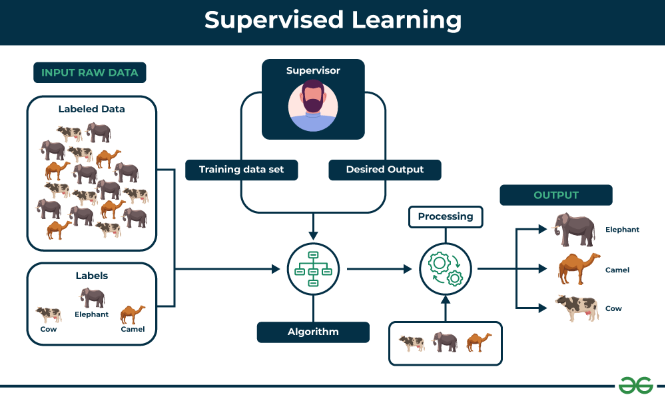

#### 08.01.02 Regression
predicting continuous target variables, which represent numerical values

##### 08.01.02.01 Linear Regression

In [67]:
from sklearn.linear_model import LinearRegression

In [68]:
def single_lir(x_var, y_var, save = False, graph = False):
  for i in x_var:
    for j in y_var:
      try:
        title = 'Linear Regression Model ' + i + ' & ' + j
        x = np.array(df[i])
        y = np.array(df[j])
        x = x.reshape(-1, 1)
        model = LinearRegression()
        train = model.fit(x, y)
        y_predicted = model.predict(x)
        training_score = model.score(x, y)

        print('=' * 100)
        print(title)
        print('-' * 100)
        print('Training Score : ', str(round(training_score * 100, 2)), '%')
        print('Coefficients : ', model.coef_)
        print('Mean Squared Error: %.2f' % mean_squared_error(y, y_predicted))
        print('Coefficient of Determination: %.2f' % r2_score(y, y_predicted))
        print('-' * 100)

        if save == True:
          with open(title + '.sav', 'wb') as f:
            pickle.dump(train, f)
            print(title, 'has been saved')
            print('=' * 100)
        else:
          pass

        if graph == True:
          plt.scatter(x, y, color = 'red')
          plt.plot(x, y_predicted, color = 'k')
          plt.xlabel(i)
          plt.ylabel(j)
          plt.show()
        else:
          pass
      except:
        pass

Linear Regression Model age & charges
----------------------------------------------------------------------------------------------------
Training Score :  0.42 %
Coefficients :  [20.0378651]
Mean Squared Error: 18206712.34
Coefficient of Determination: 0.00
----------------------------------------------------------------------------------------------------


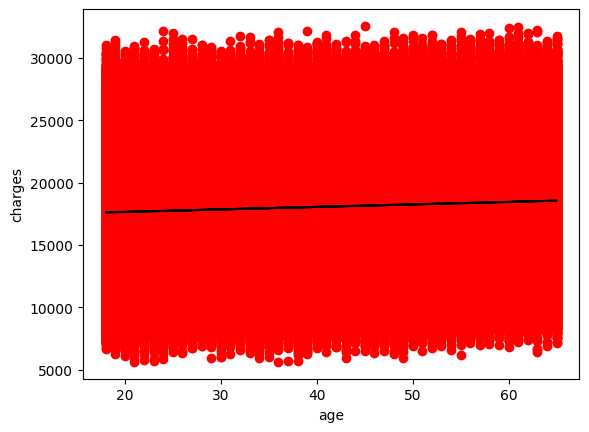

Linear Regression Model gender & charges
----------------------------------------------------------------------------------------------------
Training Score :  1.34 %
Coefficients :  [988.40593791]
Mean Squared Error: 18039581.07
Coefficient of Determination: 0.01
----------------------------------------------------------------------------------------------------


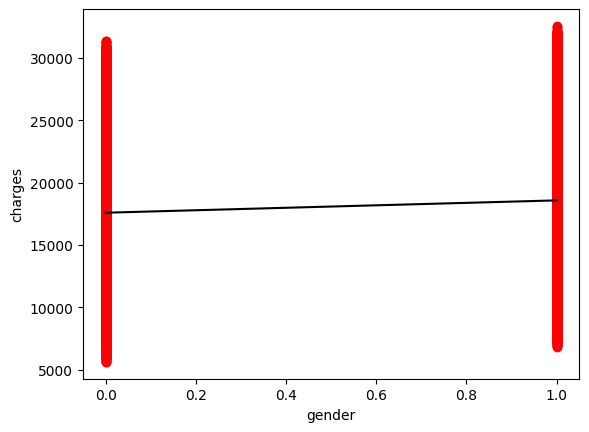

Linear Regression Model bmi & charges
----------------------------------------------------------------------------------------------------
Training Score :  1.19 %
Coefficients :  [50.50552164]
Mean Squared Error: 18066266.53
Coefficient of Determination: 0.01
----------------------------------------------------------------------------------------------------


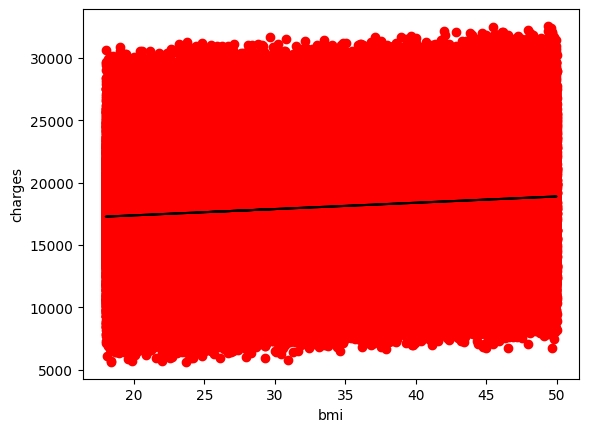

Linear Regression Model children & charges
----------------------------------------------------------------------------------------------------
Training Score :  0.64 %
Coefficients :  [200.47859367]
Mean Squared Error: 18166556.52
Coefficient of Determination: 0.01
----------------------------------------------------------------------------------------------------


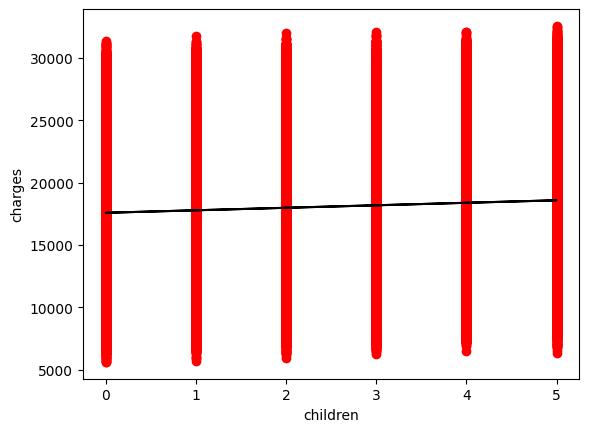

Linear Regression Model smoker & charges
----------------------------------------------------------------------------------------------------
Training Score :  34.31 %
Coefficients :  [5009.16520429]
Mean Squared Error: 12010885.45
Coefficient of Determination: 0.34
----------------------------------------------------------------------------------------------------


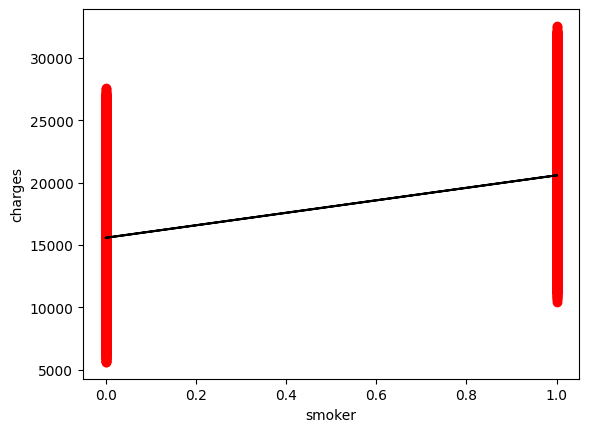

Linear Regression Model region & charges
----------------------------------------------------------------------------------------------------
Training Score :  0.33 %
Coefficients :  [-219.75700558]
Mean Squared Error: 18223370.61
Coefficient of Determination: 0.00
----------------------------------------------------------------------------------------------------


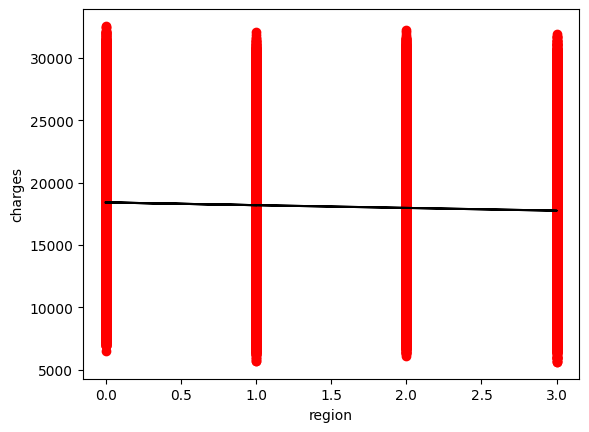

Linear Regression Model medical_history & charges
----------------------------------------------------------------------------------------------------
Training Score :  0.94 %
Coefficients :  [-506.83750026]
Mean Squared Error: 18112845.81
Coefficient of Determination: 0.01
----------------------------------------------------------------------------------------------------


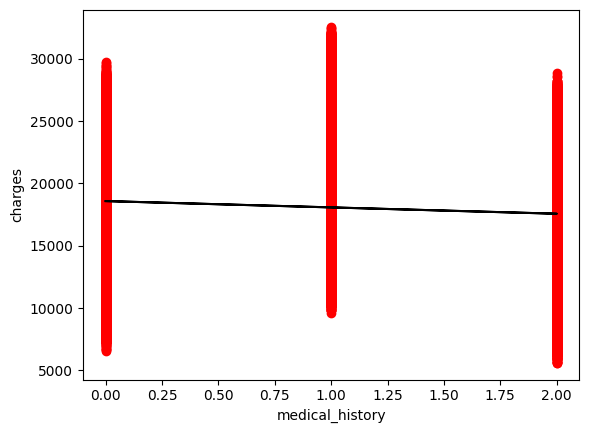

Linear Regression Model family_medical_history & charges
----------------------------------------------------------------------------------------------------
Training Score :  0.92 %
Coefficients :  [-501.49679748]
Mean Squared Error: 18116186.40
Coefficient of Determination: 0.01
----------------------------------------------------------------------------------------------------


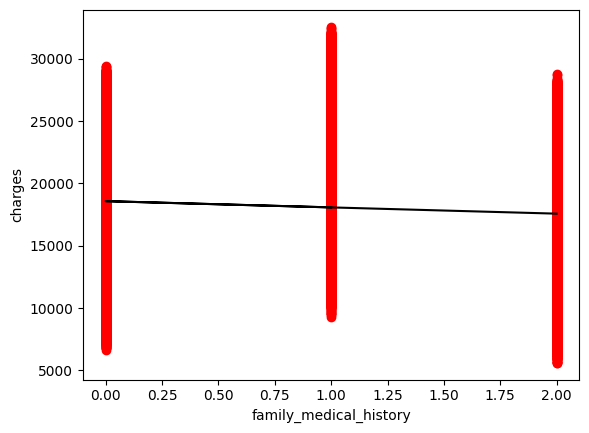

Linear Regression Model exercise_frequency & charges
----------------------------------------------------------------------------------------------------
Training Score :  0.82 %
Coefficients :  [-345.94861352]
Mean Squared Error: 18134244.41
Coefficient of Determination: 0.01
----------------------------------------------------------------------------------------------------


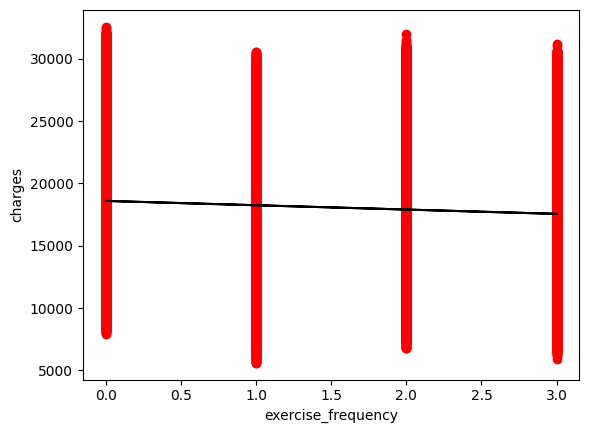

Linear Regression Model occupation & charges
----------------------------------------------------------------------------------------------------
Training Score :  0.07 %
Coefficients :  [98.99264521]
Mean Squared Error: 18271591.46
Coefficient of Determination: 0.00
----------------------------------------------------------------------------------------------------


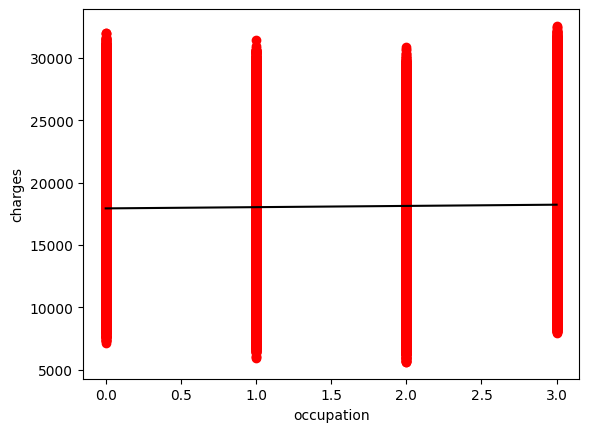

Linear Regression Model coverage_level & charges
----------------------------------------------------------------------------------------------------
Training Score :  3.68 %
Coefficients :  [1004.38617129]
Mean Squared Error: 17610754.16
Coefficient of Determination: 0.04
----------------------------------------------------------------------------------------------------


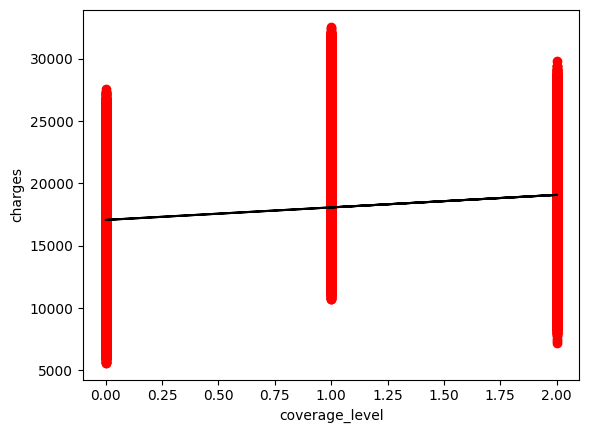

In [69]:
single_lir(x_var, y_var, save = False, graph = True)

In [70]:
def multi_lir(x_var, y_var, save = False):
  try:
    title = 'Multi Linear Regression Model'
    x = np.array(df[x_var])
    y = np.array(df[y_var])
    model = LinearRegression()
    train = model.fit(x, y)
    y_predicted = model.predict(x)
    training_score = model.score(x, y)

    print('=' * 100)
    print(title)
    print('-' * 100)
    print('Training Score : ', str(round(training_score * 100, 2)), '%')
    print('Coefficients : ', model.coef_)
    print('Mean Squared Error: %.2f' % mean_squared_error(y, y_predicted))
    print('Coefficient of Determination: %.2f' % r2_score(y, y_predicted))
    print('-' * 100)

    if save == True:
      with open(title + '.sav', 'wb') as f:
        pickle.dump(train, f)
        print(title, 'has been saved')
        print('=' * 100)
    else:
      pass
  except:
    pass

In [71]:
multi_lir(x_var, y_var, save = False)

Multi Linear Regression Model
----------------------------------------------------------------------------------------------------
Training Score :  44.56 %
Coefficients :  [[  19.97073142  996.92404447   50.17008358  199.12893084 5003.30448252
  -219.80094408 -499.59057211 -499.13044505 -342.01593601  101.21412232
   998.09219286]]
Mean Squared Error: 10137414.12
Coefficient of Determination: 0.45
----------------------------------------------------------------------------------------------------


##### 08.01.02.02 Polynomial Regression

In [72]:
from sklearn.preprocessing import PolynomialFeatures

In [73]:
def single_pr(x_var, y_var, degree = 5, save = False, graph = False):
  for i in x_var:
    for j in y_var:
      try:
        title = 'Polynomial Regression Model ' + i + ' & ' + j
        model = LinearRegression()
        poly = PolynomialFeatures(degree = degree, include_bias = True)
        x = np.array(df[i])
        y = np.array(df[j])
        x_poly = poly.fit_transform(x.reshape(-1, 1))
        train = model.fit(x_poly, y)
        y_predicted = model.predict(x_poly)
        training_score = model.score(x_poly, y)

        print('=' * 100)
        print(title)
        print('-' * 100)
        print('Training Score : ', str(round(training_score * 100, 2)), '%')
        print('Coefficients : ', model.coef_)
        print('Mean Squared Error: %.2f' % mean_squared_error(y, y_predicted))
        print('Coefficient of Determination: %.2f' % r2_score(y, y_predicted))
        print('-' * 100)

        if save == True:
          with open(title + '.sav', 'wb') as f:
            pickle.dump(train, f)
            print(title, 'has been saved')
            print('=' * 100)
        else:
          pass

        if graph == True:
          plt.scatter(x, y, color = 'red')
          plt.plot(x, y_predicted, color = 'k')
          plt.xlabel(i)
          plt.ylabel(j)
          plt.show()
        else:
          pass
      except:
        pass

In [74]:
single_pr(x_var, y_var, degree = 5, save = False, graph = False)

Polynomial Regression Model age & charges
----------------------------------------------------------------------------------------------------
Training Score :  0.42 %
Coefficients :  [ 0.00000000e+00  8.04336652e+00  1.65139281e+00 -6.55184437e-02
  1.04898677e-03 -5.92544422e-06]
Mean Squared Error: 18206651.98
Coefficient of Determination: 0.00
----------------------------------------------------------------------------------------------------
Polynomial Regression Model gender & charges
----------------------------------------------------------------------------------------------------
Training Score :  1.34 %
Coefficients :  [ 0.00000000e+00  6.29123310e+14 -1.57280828e+14 -1.57280828e+14
 -1.57280828e+14 -1.57280828e+14]
Mean Squared Error: 18039582.17
Coefficient of Determination: 0.01
----------------------------------------------------------------------------------------------------
Polynomial Regression Model bmi & charges
-----------------------------------------------------

In [75]:
def multi_pr(x_var, y_var, degree = 5, save = False):
  try:
    title = 'Multi Polynomial Regression Model'
    model = LinearRegression()
    poly = PolynomialFeatures(degree = degree, include_bias = True)
    x = np.array(df[x_var])
    y = np.array(df[y_var])
    x_poly = poly.fit_transform(x)
    train = model.fit(x_poly, y)
    y_predicted = model.predict(x_poly)
    training_score = model.score(x_poly, y)

    print('=' * 100)
    print(title)
    print('-' * 100)
    print('Training Score : ', str(round(training_score * 100, 2)), '%')
    print('Coefficients : ', model.coef_)
    print('Mean Squared Error: %.2f' % mean_squared_error(y, y_predicted))
    print('Coefficient of Determination: %.2f' % r2_score(y, y_predicted))
    print('-' * 100)

    if save == True:
      with open(title + '.sav', 'wb') as f:
        pickle.dump(train, f)
        print(title, 'has been saved')
        print('=' * 100)
    else:
      pass
  except:
    pass

In [76]:
#multi_pr(x_var, y_var, degree = 5, save = True)

##### 08.01.02.03 Lasso Regression

In [77]:
from sklearn.linear_model import Lasso

In [78]:
def single_lar(x_var, y_var, alpha = 0.01, save = False, graph = False):
  for i in x_var:
    for j in y_var:
      try:
        title = 'Lasso Regression Model ' + i + ' & ' + j
        model = Lasso(alpha = alpha, max_iter = 200, tol = 0.1)
        x = np.array(df[i])
        y = np.array(df[j])
        x = x.reshape(-1, 1)
        train = model.fit(x, y)
        y_predicted = model.predict(x)
        training_score = model.score(x, y)

        print('=' * 100)
        print(title)
        print('-' * 100)
        print('Training Score : ', str(round(training_score * 100, 2)), '%')
        print('Coefficients : ', model.coef_)
        print('Mean Squared Error: %.2f' % mean_squared_error(y, y_predicted))
        print('Coefficient of Determination: %.2f' % r2_score(y, y_predicted))
        print('-' * 100)

        if save == True:
          with open(title + '.sav', 'wb') as f:
            pickle.dump(train, f)
            print(title, 'has been saved')
            print('=' * 100)
        else:
          pass

        if graph == True:
          plt.scatter(x, y, color = 'red')
          plt.plot(x, y_predicted, color = 'k')
          plt.xlabel(i)
          plt.ylabel(j)
          plt.show()
        else:
          pass
      except:
        pass

Lasso Regression Model age & charges
----------------------------------------------------------------------------------------------------
Training Score :  0.42 %
Coefficients :  [20.03786458]
Mean Squared Error: 18206712.34
Coefficient of Determination: 0.00
----------------------------------------------------------------------------------------------------


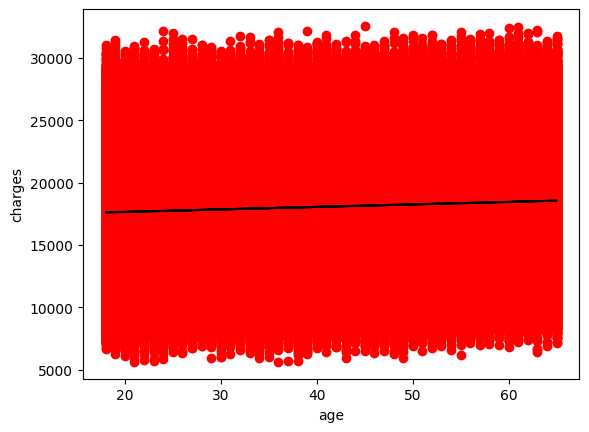

Lasso Regression Model gender & charges
----------------------------------------------------------------------------------------------------
Training Score :  1.34 %
Coefficients :  [988.40553791]
Mean Squared Error: 18039581.07
Coefficient of Determination: 0.01
----------------------------------------------------------------------------------------------------


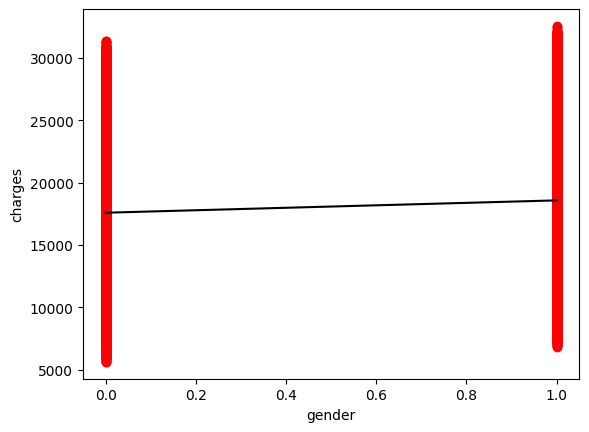

Lasso Regression Model bmi & charges
----------------------------------------------------------------------------------------------------
Training Score :  1.19 %
Coefficients :  [50.50552047]
Mean Squared Error: 18066266.53
Coefficient of Determination: 0.01
----------------------------------------------------------------------------------------------------


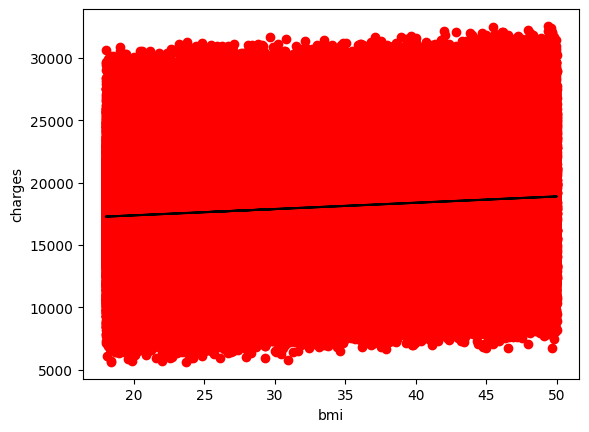

Lasso Regression Model children & charges
----------------------------------------------------------------------------------------------------
Training Score :  0.64 %
Coefficients :  [200.47855939]
Mean Squared Error: 18166556.52
Coefficient of Determination: 0.01
----------------------------------------------------------------------------------------------------


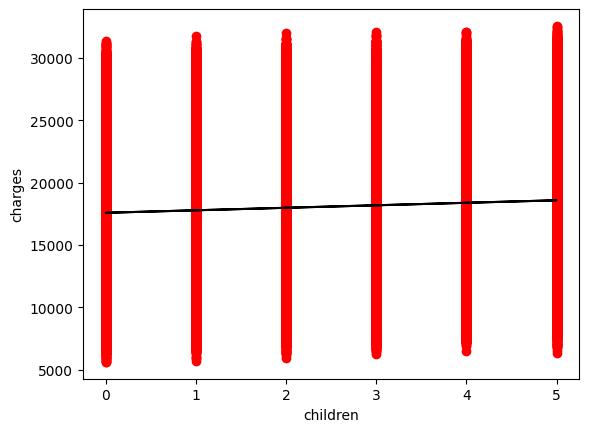

Lasso Regression Model smoker & charges
----------------------------------------------------------------------------------------------------
Training Score :  34.31 %
Coefficients :  [5009.16480429]
Mean Squared Error: 12010885.45
Coefficient of Determination: 0.34
----------------------------------------------------------------------------------------------------


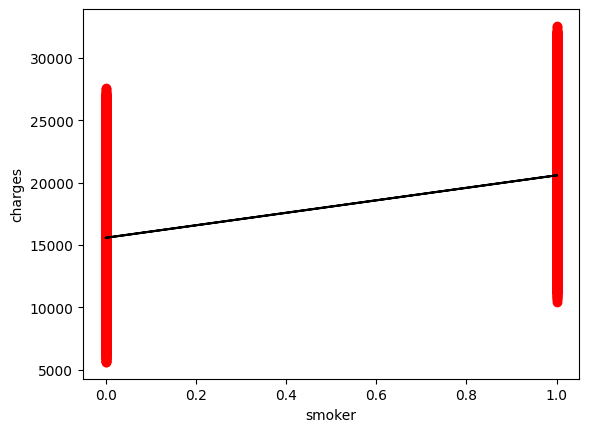

Lasso Regression Model region & charges
----------------------------------------------------------------------------------------------------
Training Score :  0.33 %
Coefficients :  [-219.75692569]
Mean Squared Error: 18223370.61
Coefficient of Determination: 0.00
----------------------------------------------------------------------------------------------------


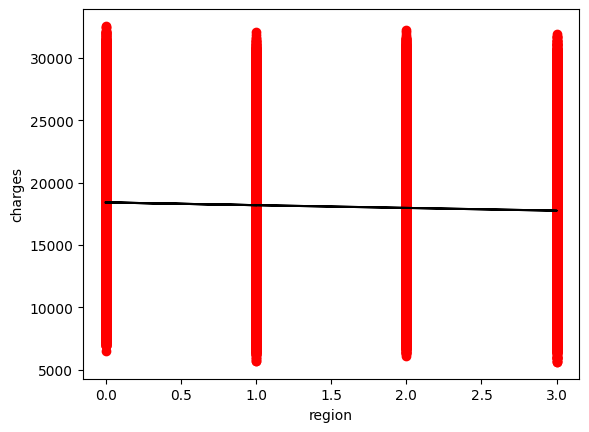

Lasso Regression Model medical_history & charges
----------------------------------------------------------------------------------------------------
Training Score :  0.94 %
Coefficients :  [-506.83735001]
Mean Squared Error: 18112845.81
Coefficient of Determination: 0.01
----------------------------------------------------------------------------------------------------


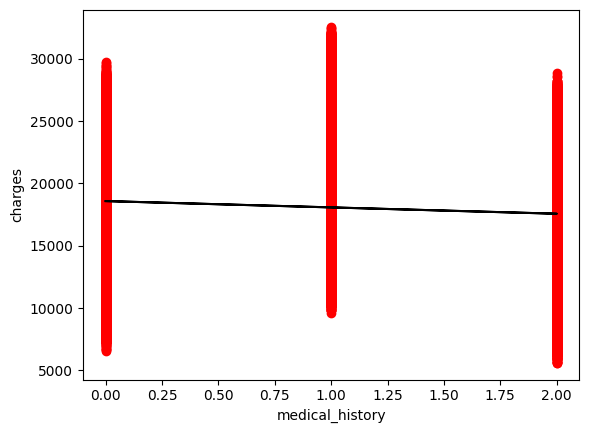

Lasso Regression Model family_medical_history & charges
----------------------------------------------------------------------------------------------------
Training Score :  0.92 %
Coefficients :  [-501.49664745]
Mean Squared Error: 18116186.40
Coefficient of Determination: 0.01
----------------------------------------------------------------------------------------------------


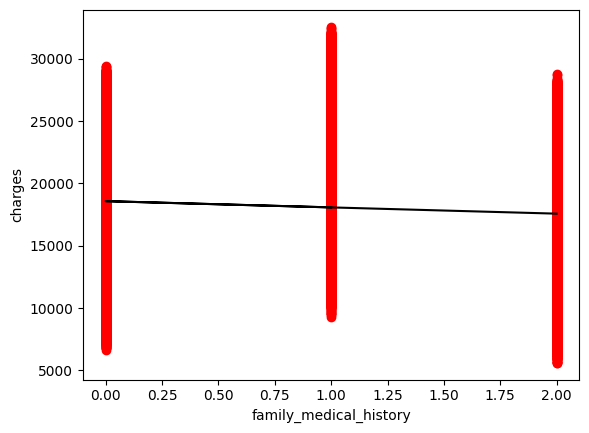

Lasso Regression Model exercise_frequency & charges
----------------------------------------------------------------------------------------------------
Training Score :  0.82 %
Coefficients :  [-345.94853351]
Mean Squared Error: 18134244.41
Coefficient of Determination: 0.01
----------------------------------------------------------------------------------------------------


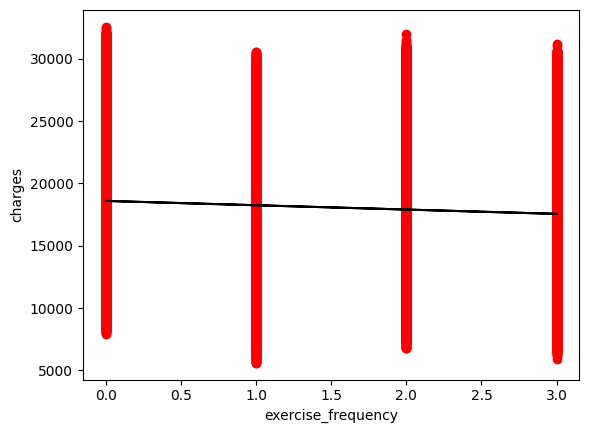

Lasso Regression Model occupation & charges
----------------------------------------------------------------------------------------------------
Training Score :  0.07 %
Coefficients :  [98.99256506]
Mean Squared Error: 18271591.46
Coefficient of Determination: 0.00
----------------------------------------------------------------------------------------------------


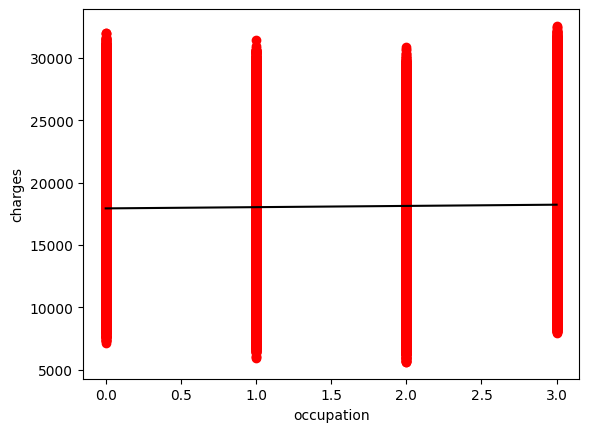

Lasso Regression Model coverage_level & charges
----------------------------------------------------------------------------------------------------
Training Score :  3.68 %
Coefficients :  [1004.38602141]
Mean Squared Error: 17610754.16
Coefficient of Determination: 0.04
----------------------------------------------------------------------------------------------------


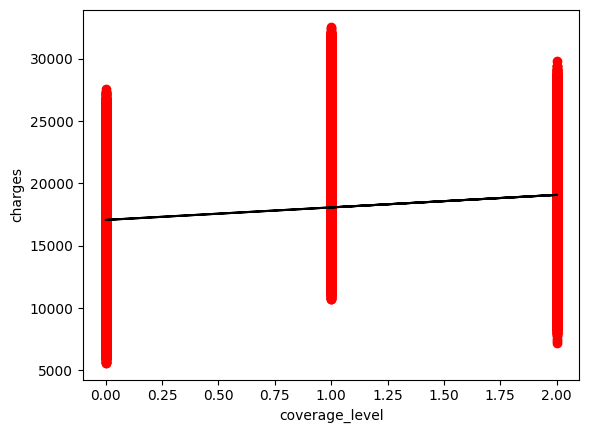

In [79]:
single_lar(x_var, y_var, alpha = 0.0001, save = False, graph = True)

In [80]:
def multi_lar(x_var, y_var, alpha = 0.01, save = False):
  try:
    title = 'Multi Lasso Regression Model'
    model = Lasso(alpha = alpha, max_iter = 200, tol = 0.1)
    x = np.array(df[x_var])
    y = np.array(df[y_var])
    train = model.fit(x, y)
    y_predicted = model.predict(x)
    training_score = model.score(x, y)

    print('=' * 100)
    print(title)
    print('-' * 100)
    print('Training Score : ', str(round(training_score * 100, 2)), '%')
    print('Coefficients : ', model.coef_)
    print('Mean Squared Error: %.2f' % mean_squared_error(y, y_predicted))
    print('Coefficient of Determination: %.2f' % r2_score(y, y_predicted))
    print('-' * 100)

    if save == True:
      with open(title + '.sav', 'wb') as f:
        pickle.dump(train, f)
        print(title, 'has been saved')
        print('=' * 100)
    else:
      pass
  except:
    pass

In [81]:
multi_lar(x_var, y_var, alpha = 0.01, save = False)

Multi Lasso Regression Model
----------------------------------------------------------------------------------------------------
Training Score :  44.56 %
Coefficients :  [  19.9706771   996.8839677    50.16996494  199.125513   5003.26450803
 -219.79297081 -499.57558347 -499.11552155 -342.00796979  101.20611862
  998.07732992]
Mean Squared Error: 10137414.12
Coefficient of Determination: 0.45
----------------------------------------------------------------------------------------------------


##### 08.01.02.04 Ridge Regression

In [82]:
from sklearn.linear_model import Ridge

In [83]:
def single_rr(x_var, y_var, alpha = 0.01, save = False, graph = False):
  for i in x_var:
    for j in y_var:
      try:
        title = 'Ridge Regression Model ' + i + ' & ' + j
        model = Ridge(alpha = alpha, max_iter = 100, tol = 0.1)
        x = np.array(df[i])
        y = np.array(df[j])
        x = x.reshape(-1, 1)
        train = model.fit(x, y)
        y_predicted = model.predict(x)
        training_score = model.score(x, y)

        print('=' * 100)
        print(title)
        print('-' * 100)
        print('Training Score : ', str(round(training_score * 100, 2)), '%')
        print('Coefficients : ', model.coef_)
        print('Mean Squared Error: %.2f' % mean_squared_error(y, y_predicted))
        print('Coefficient of Determination: %.2f' % r2_score(y, y_predicted))
        print('-' * 100)

        if save == True:
          with open(title + '.sav', 'wb') as f:
            pickle.dump(train, f)
            print(title, 'has been saved')
            print('=' * 100)
        else:
          pass

        if graph == True:
          plt.scatter(x, y, color = 'red')
          plt.plot(x, y_predicted, color = 'k')
          plt.xlabel(i)
          plt.ylabel(j)
          plt.show()
        else:
          pass
      except:
        pass

Ridge Regression Model age & charges
----------------------------------------------------------------------------------------------------
Training Score :  0.42 %
Coefficients :  [20.0378651]
Mean Squared Error: 18206712.34
Coefficient of Determination: 0.00
----------------------------------------------------------------------------------------------------


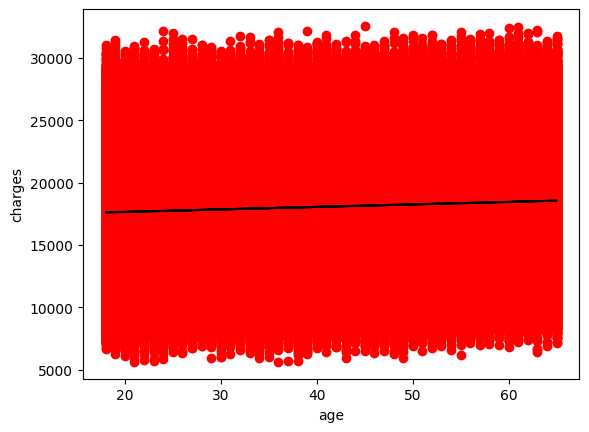

Ridge Regression Model gender & charges
----------------------------------------------------------------------------------------------------
Training Score :  1.34 %
Coefficients :  [988.4059372]
Mean Squared Error: 18039581.07
Coefficient of Determination: 0.01
----------------------------------------------------------------------------------------------------


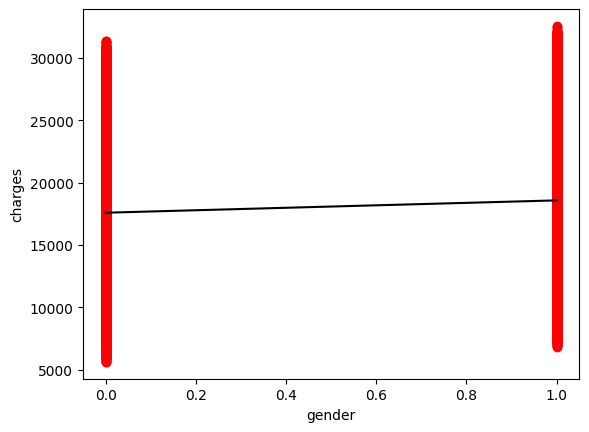

Ridge Regression Model bmi & charges
----------------------------------------------------------------------------------------------------
Training Score :  1.19 %
Coefficients :  [50.50552164]
Mean Squared Error: 18066266.53
Coefficient of Determination: 0.01
----------------------------------------------------------------------------------------------------


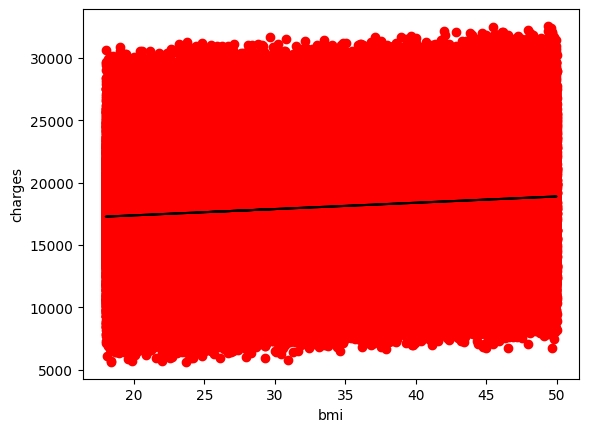

Ridge Regression Model children & charges
----------------------------------------------------------------------------------------------------
Training Score :  0.64 %
Coefficients :  [200.47859365]
Mean Squared Error: 18166556.52
Coefficient of Determination: 0.01
----------------------------------------------------------------------------------------------------


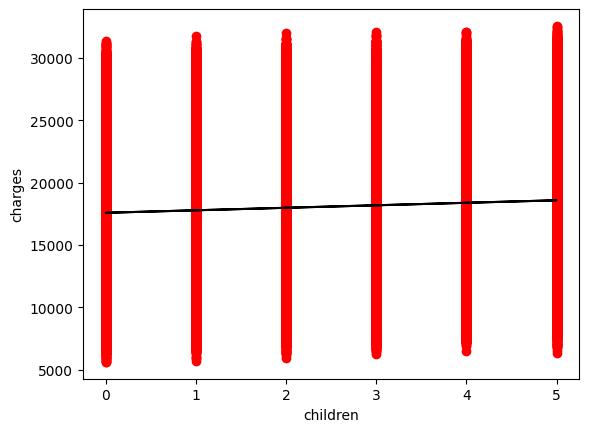

Ridge Regression Model smoker & charges
----------------------------------------------------------------------------------------------------
Training Score :  34.31 %
Coefficients :  [5009.16520072]
Mean Squared Error: 12010885.45
Coefficient of Determination: 0.34
----------------------------------------------------------------------------------------------------


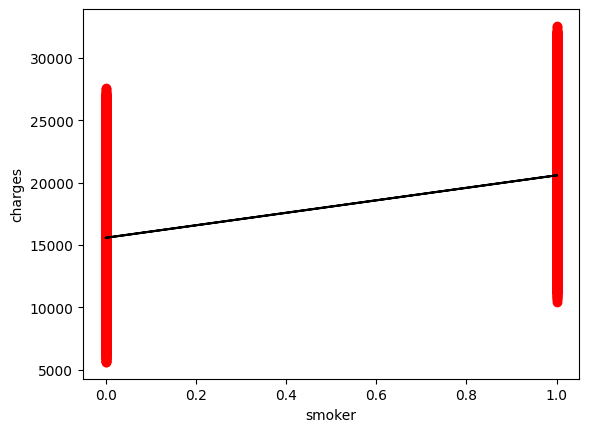

Ridge Regression Model region & charges
----------------------------------------------------------------------------------------------------
Training Score :  0.33 %
Coefficients :  [-219.75700555]
Mean Squared Error: 18223370.61
Coefficient of Determination: 0.00
----------------------------------------------------------------------------------------------------


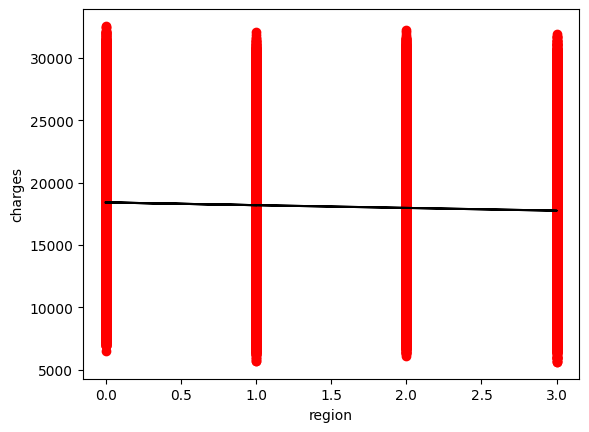

Ridge Regression Model medical_history & charges
----------------------------------------------------------------------------------------------------
Training Score :  0.94 %
Coefficients :  [-506.83750013]
Mean Squared Error: 18112845.81
Coefficient of Determination: 0.01
----------------------------------------------------------------------------------------------------


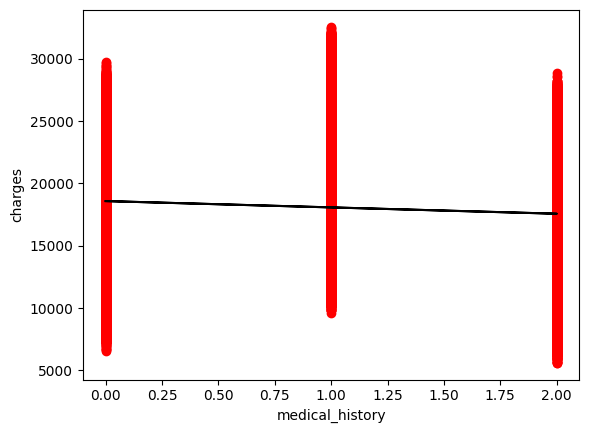

Ridge Regression Model family_medical_history & charges
----------------------------------------------------------------------------------------------------
Training Score :  0.92 %
Coefficients :  [-501.49679735]
Mean Squared Error: 18116186.40
Coefficient of Determination: 0.01
----------------------------------------------------------------------------------------------------


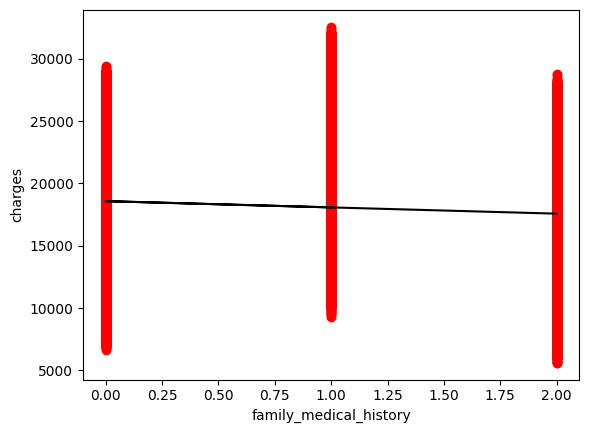

Ridge Regression Model exercise_frequency & charges
----------------------------------------------------------------------------------------------------
Training Score :  0.82 %
Coefficients :  [-345.94861347]
Mean Squared Error: 18134244.41
Coefficient of Determination: 0.01
----------------------------------------------------------------------------------------------------


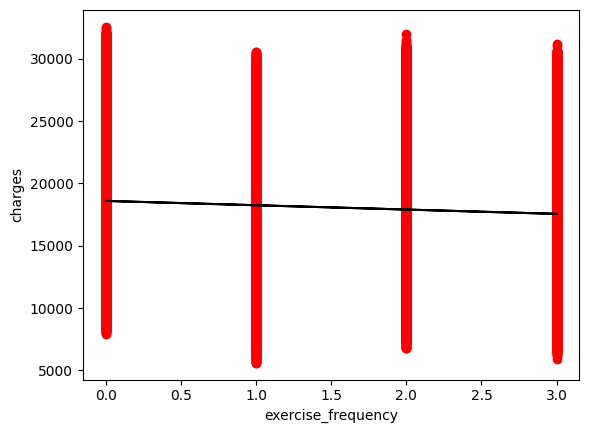

Ridge Regression Model occupation & charges
----------------------------------------------------------------------------------------------------
Training Score :  0.07 %
Coefficients :  [98.9926452]
Mean Squared Error: 18271591.46
Coefficient of Determination: 0.00
----------------------------------------------------------------------------------------------------


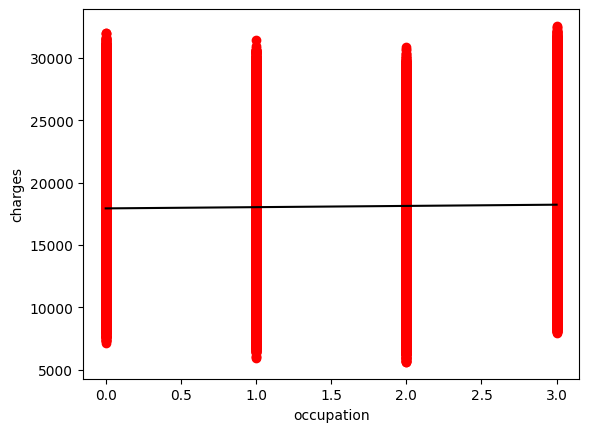

Ridge Regression Model coverage_level & charges
----------------------------------------------------------------------------------------------------
Training Score :  3.68 %
Coefficients :  [1004.38617102]
Mean Squared Error: 17610754.16
Coefficient of Determination: 0.04
----------------------------------------------------------------------------------------------------


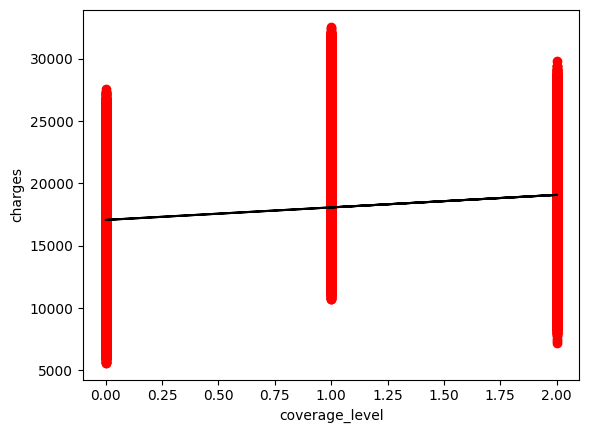

In [84]:
single_rr(x_var, y_var, alpha = 0.0001, save = False, graph = True)

In [85]:
def multi_rr(x_var, y_var, alpha = 0.01, save = False):
  try:
    title = 'Multi Ridge Regression Model'
    model = Ridge(alpha = alpha, max_iter = 100, tol = 0.1)
    x = np.array(df[x_var])
    y = np.array(df[y_var])
    train = model.fit(x, y)
    y_predicted = model.predict(x)
    training_score = model.score(x, y)

    print('=' * 100)
    print(title)
    print('-' * 100)
    print('Training Score : ', str(round(training_score * 100, 2)), '%')
    print('Coefficients : ', model.coef_)
    print('Mean Squared Error: %.2f' % mean_squared_error(y, y_predicted))
    print('Coefficient of Determination: %.2f' % r2_score(y, y_predicted))
    print('-' * 100)

    if save == True:
      with open(title + '.sav', 'wb') as f:
        pickle.dump(train, f)
        print(title, 'has been saved')
        print('=' * 100)
    else:
      pass
  except:
    pass

In [86]:
multi_rr(x_var, y_var, alpha = 0.01, save = False)

Multi Ridge Regression Model
----------------------------------------------------------------------------------------------------
Training Score :  44.56 %
Coefficients :  [[  19.97073141  996.92397293   50.1700836   199.12892972 5003.30412621
  -219.80094096 -499.59055939 -499.13043161 -342.01593139  101.2141207
   998.09216663]]
Mean Squared Error: 10137414.12
Coefficient of Determination: 0.45
----------------------------------------------------------------------------------------------------


##### 08.01.02.05 Decision tree

In [87]:
from sklearn.tree import DecisionTreeRegressor

In [88]:
def single_dtr(x_var, y_var, save = False, graph = False):
  for i in x_var:
    for j in y_var:
      try:
        title = 'Decision Tree Regressor Model ' + i + ' & ' + j
        model = DecisionTreeRegressor(random_state = 0)
        x = np.array(df[i])
        y = np.array(df[j])
        x = x.reshape(-1, 1)
        train = model.fit(x, y)
        y_predicted = model.predict(x)
        training_score = model.score(x, y)

        print('=' * 100)
        print(title)
        print('-' * 100)
        print('Training Score : ', str(round(training_score * 100, 2)), '%')
        print('Mean Squared Error: %.2f' % mean_squared_error(y, y_predicted))
        print('Coefficient of Determination: %.2f' % r2_score(y, y_predicted))
        print('-' * 100)

        if save == True:
          with open(title + '.sav', 'wb') as f:
            pickle.dump(train, f)
            print(title, 'has been saved')
            print('=' * 100)
        else:
          pass

        if graph == True:
          plt.scatter(x, y, color = 'red')
          plt.plot(x, y_predicted, color = 'k')
          plt.xlabel(i)
          plt.ylabel(j)
          plt.show()
        else:
          pass
      except:
        pass

In [89]:
single_dtr(x_var, y_var, save = False, graph = False)

Decision Tree Regressor Model age & charges
----------------------------------------------------------------------------------------------------
Training Score :  0.43 %
Mean Squared Error: 18205026.49
Coefficient of Determination: 0.00
----------------------------------------------------------------------------------------------------
Decision Tree Regressor Model gender & charges
----------------------------------------------------------------------------------------------------
Training Score :  1.34 %
Mean Squared Error: 18039581.07
Coefficient of Determination: 0.01
----------------------------------------------------------------------------------------------------
Decision Tree Regressor Model bmi & charges
----------------------------------------------------------------------------------------------------
Training Score :  1.74 %
Mean Squared Error: 17965245.24
Coefficient of Determination: 0.02
------------------------------------------------------------------------------------

In [90]:
def multi_dtr(x_var, y_var, alpha = 0.01, save = False):
  try:
    title = 'Multi Decision Tree Regressor Model'
    model = DecisionTreeRegressor(random_state = 0)
    x = np.array(df[x_var])
    y = np.array(df[y_var])
    train = model.fit(x, y)
    y_predicted = model.predict(x)
    training_score = model.score(x, y)

    print('=' * 100)
    print(title)
    print('-' * 100)
    print('Training Score : ', str(round(training_score * 100, 2)), '%')
    print('Mean Squared Error: %.2f' % mean_squared_error(y, y_predicted))
    print('Coefficient of Determination: %.2f' % r2_score(y, y_predicted))
    print('-' * 100)

    if save == True:
      with open(title + '.sav', 'wb') as f:
        pickle.dump(train, f)
        print(title, 'has been saved')
        print('=' * 100)
    else:
      pass
  except:
    pass

In [91]:
multi_dtr(x_var, y_var, alpha = 0.01, save = False)

Multi Decision Tree Regressor Model
----------------------------------------------------------------------------------------------------
Training Score :  100.0 %
Mean Squared Error: 3.72
Coefficient of Determination: 1.00
----------------------------------------------------------------------------------------------------


##### 08.01.02.06 Random Forest Regressor

In [92]:
from sklearn.ensemble import RandomForestRegressor

In [93]:
def single_rfr(x_var, y_var, n_estimators = 10, save = False, graph = False):
  for i in x_var:
    for j in y_var:
      try:
        title = 'Random Forest Regressor Model ' + i + ' & ' + j
        model = RandomForestRegressor(n_estimators = n_estimators, random_state = 0)
        x = np.array(df[i])
        y = np.array(df[j])
        x = x.reshape(-1, 1)
        train = model.fit(x, y)
        y_predicted = model.predict(x)
        training_score = model.score(x, y)

        print('=' * 100)
        print(title)
        print('-' * 100)
        print('Training Score : ', str(round(training_score * 100, 2)), '%')
        print('Mean Squared Error: %.2f' % mean_squared_error(y, y_predicted))
        print('Coefficient of Determination: %.2f' % r2_score(y, y_predicted))
        print('-' * 100)

        if save == True:
          with open(title + '.sav', 'wb') as f:
            pickle.dump(train, f)
            print(title, 'has been saved')
            print('=' * 100)
        else:
          pass

        if graph == True:
          plt.scatter(x, y, color = 'red')
          plt.plot(x, y_predicted, color = 'k')
          plt.xlabel(i)
          plt.ylabel(j)
          plt.show()
        else:
          pass
      except:
        pass

In [94]:
single_rfr(x_var, y_var, n_estimators = 10, save = False, graph = False)

Random Forest Regressor Model age & charges
----------------------------------------------------------------------------------------------------
Training Score :  0.43 %
Mean Squared Error: 18205201.62
Coefficient of Determination: 0.00
----------------------------------------------------------------------------------------------------
Random Forest Regressor Model gender & charges
----------------------------------------------------------------------------------------------------
Training Score :  1.34 %
Mean Squared Error: 18039586.58
Coefficient of Determination: 0.01
----------------------------------------------------------------------------------------------------
Random Forest Regressor Model bmi & charges
----------------------------------------------------------------------------------------------------
Training Score :  1.69 %
Mean Squared Error: 17975351.22
Coefficient of Determination: 0.02
------------------------------------------------------------------------------------

In [95]:
def multi_rfr(x_var, y_var, n_estimators = 10, save = False):
  try:
    title = 'Multi Random Forest Regressor Model'
    model = RandomForestRegressor(n_estimators = n_estimators, random_state = 0)
    x = np.array(df[x_var])
    y = np.array(df[y_var])
    train = model.fit(x, y)
    y_predicted = model.predict(x)
    training_score = model.score(x, y)

    print('=' * 100)
    print(title)
    print('-' * 100)
    print('Training Score : ', str(round(training_score * 100, 2)), '%')
    print('Mean Squared Error: %.2f' % mean_squared_error(y, y_predicted))
    print('Coefficient of Determination: %.2f' % r2_score(y, y_predicted))
    print('-' * 100)

    if save == True:
      with open(title + '.sav', 'wb') as f:
        pickle.dump(train, f)
        print(title, 'has been saved')
        print('=' * 100)
    else:
      pass
  except:
    pass

In [96]:
multi_rfr(x_var, y_var, n_estimators = 10, save = False)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Multi Random Forest Regressor Model
----------------------------------------------------------------------------------------------------
Training Score :  99.86 %
Mean Squared Error: 25403.17
Coefficient of Determination: 1.00
----------------------------------------------------------------------------------------------------


##### 08.01.02.07 Grid Search

In [97]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [98]:
model_params = {
  'linear_regression' : {
    'model' : LinearRegression(),
    'params' : {
      #'C' : [1, 5, 10]
    }
  },
  'lasso_regression' : {
    'model' : Lasso(),
    'params' : {
      'alpha' : [1, 10, 100],
      'max_iter' : [1, 10, 100],
      'tol' : [0.1, 0.01]
    }
  },
  'ridge_regression' : {
    'model' : Ridge(),
    'params' : {
      'alpha' : [1, 10, 100],
      'max_iter' : [1, 10, 100],
      'tol' : [0.1, 0.01]
    }
  },
  'decision_tree_regressor' : {
    'model' : DecisionTreeRegressor(),
    'params' : {
      'random_state' : [0, 42]
    }
  },
  'random_forest_regressor' : {
    'model' : RandomForestRegressor(),
    'params' : {
      'n_estimators' : [1, 5, 10],
      'random_state' : [0, 42]
    }
  },
}

In [99]:
def single_gsc(x_var, y_var, model_params, cv = 5):
  try:
    scores = []

    for i in x_var:
      for j in y_var:
        x = np.array(df[i])
        y = np.array(df[j])
        x = x.reshape(-1, 1)

        for model_name, mp in model_params.items():
          model = GridSearchCV(mp['model'], mp['params'], cv = cv, return_train_score = False)
          model.fit(x, y)
          scores.append({
              'model': model_name + ' ' + i + ' & ' + j,
              'best_score': model.best_score_,
              'best_params': model.best_params_
          })

    tune_df = pd.DataFrame(scores, columns = ['model', 'best_score', 'best_params'])
    tune_df = tune_df.sort_values('best_score', ascending = False)
    tune_df = tune_df.reset_index(drop = True)

    display(tune_df)
  except:
    pass

In [100]:
single_gsc(x_var, y_var, model_params, cv = 2)

,model,best_score,best_params
0,random_forest_regressor smoker & charges,0.343084,"{'n_estimators': 1, 'random_state': 42}"
1,ridge_regression smoker & charges,0.343081,"{'alpha': 1, 'max_iter': 1, 'tol': 0.1}"
2,decision_tree_regressor smoker & charges,0.343081,{'random_state': 0}
3,linear_regression smoker & charges,0.343081,{}
4,lasso_regression smoker & charges,0.343080,"{'alpha': 1, 'max_iter': 1, 'tol': 0.1}"
5,decision_tree_regressor coverage_level & charges,0.231991,{'random_state': 0}
6,random_forest_regressor coverage_level & charges,0.231990,"{'n_estimators': 10, 'random_state': 0}"
7,random_forest_regressor family_medical_history...,0.159005,"{'n_estimators': 10, 'random_state': 0}"
8,decision_tree_regressor family_medical_history...,0.159005,{'random_state': 0}
9,random_forest_regressor medical_history & charges,0.158310,"{'n_estimators': 5, 'random_state': 0}"


In [101]:
def multi_gsc(x_var, y_var, model_params, cv = 5):
  try:
    scores = []

    x = np.array(df[x_var])
    y = np.array(df[y_var])

    for model_name, mp in model_params.items():
      model = GridSearchCV(mp['model'], mp['params'], cv = 5, return_train_score = False)
      model.fit(x, y)
      scores.append({
          'model': model_name,
          'best_score': model.best_score_,
          'best_params': model.best_params_
      })

    tune_df = pd.DataFrame(scores, columns = ['model', 'best_score', 'best_params'])
    tune_df = tune_df.sort_values('best_score', ascending = False)
    tune_df = tune_df.reset_index(drop = True)

    display(tune_df)
  except:
    pass

In [102]:
multi_gsc(x_var, y_var, model_params, cv = 2)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.166e+12, tolerance: 8.224e+11
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.062e+12, tolerance: 8.205e+11
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.173e+12, tolerance: 8.217e

,model,best_score,best_params
0,random_forest_regressor,0.992028,"{'n_estimators': 10, 'random_state': 0}"
1,decision_tree_regressor,0.985821,{'random_state': 42}
2,ridge_regression,0.445514,"{'alpha': 1, 'max_iter': 1, 'tol': 0.1}"
3,linear_regression,0.445514,{}
4,lasso_regression,0.445513,"{'alpha': 1, 'max_iter': 10, 'tol': 0.1}"


##### 08.01.02.08 Xgboost Regression

In [103]:
def xgb_single_lir(x_var, y_var, save = False, n_estimators = 10, tree = False):
  for i in x_var:
    for j in y_var:
      try:
        title = 'XGB Regression Model ' + i + ' & ' + j
        x = np.array(df[i])
        y = np.array(df[j])
        x = x.reshape(-1, 1)
        model = xgb.XGBRegressor(objective = 'reg:linear', n_estimators = n_estimators, seed = 123)
        train = model.fit(x, y)
        y_predicted = model.predict(x)

        print('=' * 100)
        print(title)
        print('-' * 100)
        print('Mean Squared Error: %.2f' % mean_squared_error(y, y_predicted))
        print('Coefficient of Determination: %.2f' % r2_score(y, y_predicted))
        print('-' * 100)

        if save == True:
          with open(title + '.sav', 'wb') as f:
            pickle.dump(train, f)
            print(title, 'has been saved')
            print('=' * 100)
        else:
          pass

        if tree == True:
          xgb.plot_tree(model, num_trees = 0)
          xgb.plot_tree(model, num_trees = 9, rankdir = 'LR')
          xgb.plot_importance(model)
          plt.show()
        else:
          pass
      except:
        pass

In [104]:
xgb_single_lir(x_var, y_var, save = False, n_estimators = 10, tree = False)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:17:22] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGB Regression Model age & charges
----------------------------------------------------------------------------------------------------
Mean Squared Error: 18205091.76
Coefficient of Determination: 0.00
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:17:23] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGB Regression Model gender & charges
----------------------------------------------------------------------------------------------------
Mean Squared Error: 18039775.92
Coefficient of Determination: 0.01
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:17:23] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGB Regression Model bmi & charges
----------------------------------------------------------------------------------------------------
Mean Squared Error: 18059836.85
Coefficient of Determination: 0.01
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:17:24] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGB Regression Model children & charges
----------------------------------------------------------------------------------------------------
Mean Squared Error: 18166536.41
Coefficient of Determination: 0.01
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:17:26] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGB Regression Model smoker & charges
----------------------------------------------------------------------------------------------------
Mean Squared Error: 12015890.81
Coefficient of Determination: 0.34
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:17:28] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGB Regression Model region & charges
----------------------------------------------------------------------------------------------------
Mean Squared Error: 18188275.94
Coefficient of Determination: 0.01
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:17:28] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGB Regression Model medical_history & charges
----------------------------------------------------------------------------------------------------
Mean Squared Error: 15391517.80
Coefficient of Determination: 0.16
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:17:28] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGB Regression Model family_medical_history & charges
----------------------------------------------------------------------------------------------------
Mean Squared Error: 15378776.09
Coefficient of Determination: 0.16
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:17:28] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGB Regression Model exercise_frequency & charges
----------------------------------------------------------------------------------------------------
Mean Squared Error: 17737636.89
Coefficient of Determination: 0.03
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:17:29] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGB Regression Model occupation & charges
----------------------------------------------------------------------------------------------------
Mean Squared Error: 17668589.84
Coefficient of Determination: 0.03
----------------------------------------------------------------------------------------------------
XGB Regression Model coverage_level & charges
----------------------------------------------------------------------------------------------------
Mean Squared Error: 14045407.54
Coefficient of Determination: 0.23
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:17:29] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [105]:
def xgb_regressor(x_var, y_var, save = False, num_round = 5):
  for i in x_var:
    for j in y_var:
      try:
        title = 'XGB Regressor Model ' + i + ' & ' + j
        x = np.array(df[i])
        y = np.array(df[j])
        x = x.reshape(-1, 1)
        dmatrix = xgb.DMatrix(data = x, label = y)
        params = {
          'booster' : 'gblinear',
          'objective' : 'reg:linear'
        }
        model = xgb.train(params = params, dtrain = dmatrix, num_boost_round = num_round)
        #y_predicted = model.predict(dmatrix)
        preds = model.predict(dmatrix)
        y_predicted = np.asarray([np.argmax(line) for line in preds])

        print('=' * 100)
        print(title)
        print('-' * 100)
        print('Mean Squared Error: %.2f' % mean_squared_error(y, y_predicted))
        print('Coefficient of Determination: %.2f' % r2_score(y, y_predicted))
        print('-' * 100)

        if save == True:
          with open(title + '.sav', 'wb') as f:
            pickle.dump(model, f)
            print(title, 'has been saved')
            print('=' * 100)
        else:
          pass
      except:
        pass

In [106]:
xgb_regressor(x_var, y_var, save = False, num_round = 5)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:17:29] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGB Regressor Model age & charges
----------------------------------------------------------------------------------------------------
Mean Squared Error: 344958831.65
Coefficient of Determination: -17.87
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:17:31] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGB Regressor Model gender & charges
----------------------------------------------------------------------------------------------------
Mean Squared Error: 344958831.65
Coefficient of Determination: -17.87
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:17:33] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGB Regressor Model bmi & charges
----------------------------------------------------------------------------------------------------
Mean Squared Error: 344958831.65
Coefficient of Determination: -17.87
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:17:35] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGB Regressor Model children & charges
----------------------------------------------------------------------------------------------------
Mean Squared Error: 344958831.65
Coefficient of Determination: -17.87
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:17:37] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGB Regressor Model smoker & charges
----------------------------------------------------------------------------------------------------
Mean Squared Error: 344958831.65
Coefficient of Determination: -17.87
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:17:40] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGB Regressor Model region & charges
----------------------------------------------------------------------------------------------------
Mean Squared Error: 344958831.65
Coefficient of Determination: -17.87
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:17:43] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGB Regressor Model medical_history & charges
----------------------------------------------------------------------------------------------------
Mean Squared Error: 344958831.65
Coefficient of Determination: -17.87
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:17:45] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGB Regressor Model family_medical_history & charges
----------------------------------------------------------------------------------------------------
Mean Squared Error: 344958831.65
Coefficient of Determination: -17.87
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:17:47] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGB Regressor Model exercise_frequency & charges
----------------------------------------------------------------------------------------------------
Mean Squared Error: 344958831.65
Coefficient of Determination: -17.87
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:17:49] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGB Regressor Model occupation & charges
----------------------------------------------------------------------------------------------------
Mean Squared Error: 344958831.65
Coefficient of Determination: -17.87
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:17:51] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGB Regressor Model coverage_level & charges
----------------------------------------------------------------------------------------------------
Mean Squared Error: 344958831.65
Coefficient of Determination: -17.87
----------------------------------------------------------------------------------------------------


In [107]:
def xgb_regcv_v1(x, y, nfold = 3, num_round = 10, seed = 123):
  try:
    dmatrix = xgb.DMatrix(data = x, label = y)
    params = {
      'objective' : 'reg:linear',
      'max_depth' : 3,
      'colsample_bytree': 0.5,
      'subsample' : 0.75,
      'gamma' : 0.25,
      'learning_rate' : 0.3,
      'reg_alpha' : 0.01,
    }
    df = xgb.cv(dtrain = dmatrix, params = params, nfold = nfold, num_boost_round = num_round, seed = num_round, metrics = 'rmse')

    print('XGB Regressor Cross Validation v1')
    print('=' * 100)

    display(df)
  except:
    pass

In [108]:
xgb_regcv_v1(x, y, nfold = 3, num_round = 10, seed = 123)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:17:54] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:17:55] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:17:56] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGB Regressor Cross Validation v1


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,3683.336901,2.947667,3683.352890,5.069359
1,3098.540055,2.513046,3098.559327,5.552633
2,2724.944750,1.421222,2724.972725,4.338427
3,2503.489177,1.169768,2503.523249,3.771528
4,2265.834235,0.858122,2265.873930,4.584186
5,2057.921982,0.449040,2057.975769,4.226650
6,1914.118421,1.757423,1914.161353,5.220126
7,1827.891497,4.283965,1828.098403,7.280803
8,1699.410883,2.036614,1699.452540,5.621606
9,1541.744207,3.053047,1541.816881,5.211501


In [109]:
def xgb_regcv_v2(x, y, nfold = 3, num_round = 10, seed = 123):
  try:
    dmatrix = xgb.DMatrix(data = x, label = y)
    params = {
      'objective' : 'reg:linear',
      'max_depth' : 3,
      'colsample_bytree': 0.5,
      'subsample' : 0.75,
      'gamma' : 0.25,
      'learning_rate' : 0.3,
      'reg_alpha' : 0.01,
      'silent' : 1
    }
    df = xgb.cv(dtrain = dmatrix, params = params, nfold = nfold, num_boost_round = num_round, seed = num_round, metrics = 'mae')

    print('XGB Regressor Cross Validation v2')
    print('=' * 100)

    display(df)
  except:
    pass

In [110]:
xgb_regcv_v2(x, y, nfold = 3, num_round = 10, seed = 123)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:17:58] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:17:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:17:59] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:17:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


XGB Regressor Cross Validation v2


,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
0,2987.568596,2.916310,2987.589125,5.198315
1,2507.177468,2.799192,2507.204055,5.913802
2,2198.549398,2.134040,2198.574018,5.435611
3,2018.375358,1.920984,2018.405690,5.016836
4,1822.992529,1.457959,1823.025497,5.176150
5,1654.860290,1.051069,1654.907529,4.956390
6,1538.514485,0.908892,1538.567198,5.513826
7,1470.163620,2.998611,1470.343913,7.093659
8,1365.722846,1.131675,1365.628151,5.312694
9,1235.232066,1.931967,1235.199175,5.087286


In [111]:
def xgb_regcv_v3(x, y, nfold = 3, num_round = 10, seed = 123):
  try:
    dmatrix = xgb.DMatrix(data = x, label = y)
    reg_params = [1, 10, 100]
    params = {
      'objective' : 'reg:linear',
      'max_depth' : 3,
      'colsample_bytree': 0.5,
      'subsample' : 0.75,
      'gamma' : 0.25,
      'learning_rate' : 0.3,
      'reg_alpha' : 0.01,
      'silent' : 1
    }

    rmses = []
    for reg in reg_params:
      params['lambda'] = reg
      model = xgb.cv(
        dtrain = dmatrix,
        params = params,
        #nfold = nfold,
        num_boost_round = num_round,
        metrics = 'rmse',
        as_pandas = True,
        seed = 123
      )
      rmses.append(model['test-rmse-mean'].tail(1).values[0])

    print('XGB Regressor Cross Validation v3')
    print('=' * 100)
    print('Best RMSE as a Function of l2 :')
    print(pd.DataFrame(list(zip(reg_params, rmses)), columns = ['l2', 'rmse']))
  except:
    pass

In [112]:
xgb_regcv_v3(x, y, nfold = 3, num_round = 10, seed = 123)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:18:01] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:18:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:18:03] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:18:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:18:04] WARNING: /workspace/src/objective/regress

XGB Regressor Cross Validation v3
Best RMSE as a Function of l2 :
    l2         rmse
0    1  1542.231567
1   10  1542.536325
2  100  1545.423018


In [113]:
def xgb_regcv_v4(x, y, nfold = 3, seed = 123):
  try:
    dmatrix = xgb.DMatrix(data = x, label = y)
    num_rounds = [5, 10, 15]
    params = {
      'objective' : 'reg:linear',
      'max_depth' : 3,
      'colsample_bytree': 0.5,
      'subsample' : 0.75,
      'gamma' : 0.25,
      'learning_rate' : 0.3,
      'reg_alpha' : 0.01,
      'silent' : 1
    }

    rmses = []
    for round in num_rounds:
      model = xgb.cv(
        dtrain = dmatrix,
        params = params,
        nfold = nfold,
        num_boost_round = round,
        metrics = 'rmse',
        as_pandas = True,
        seed = 123
      )
      rmses.append(model['test-rmse-mean'].tail().values[-1])

    print('XGB Regressor Cross Validation v4')
    print('=' * 100)
    print('Best RMSE on Rounds :')
    print(pd.DataFrame(list(zip(num_rounds, rmses)), columns = ['num_boosting_rounds', 'rmse']))
  except:
    pass

In [114]:
xgb_regcv_v4(x, y, nfold = 3, seed = 123)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:18:11] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:18:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:18:12] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:18:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:18:13] WARNING: /workspace/src/objective/regress

XGB Regressor Cross Validation v4
Best RMSE on Rounds :
   num_boosting_rounds         rmse
0                    5  2266.869102
1                   10  1542.231567
2                   15  1174.022844


In [115]:
def xgb_regcv_v5(x, y, nfold = 3, num_round = 10, seed = 123):
  try:
    dmatrix = xgb.DMatrix(data = x, label = y)
    eta_vals = [0.001, 0.01, 0.1]
    params = {
      'objective' : 'reg:linear',
      'max_depth' : 3,
      'colsample_bytree': 0.5,
      'subsample' : 0.75,
      'gamma' : 0.25,
      'learning_rate' : 0.3,
      'reg_alpha' : 0.01,
      'silent' : 1
    }

    rmses = []
    for curr_val in eta_vals:
      params['eta'] = curr_val
      model = xgb.cv(
        dtrain = dmatrix,
        params = params,
        nfold = nfold,
        num_boost_round = num_round,
        metrics = 'rmse',
        as_pandas = True,
        seed = 123
      )
      rmses.append(model['test-rmse-mean'].tail().values[-1])

    print('XGB Regressor Cross Validation v5')
    print('=' * 100)
    print('Best RMSE on Rounds :')
    print(pd.DataFrame(list(zip(eta_vals, rmses)), columns = ['eta', 'rmse']))
  except:
    pass

In [116]:
xgb_regcv_v5(x, y, nfold = 3, num_round = 10, seed = 123)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:18:19] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:18:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:18:21] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:18:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:18:22] WARNING: /workspace/src/objective/regress

XGB Regressor Cross Validation v5
Best RMSE on Rounds :
     eta         rmse
0  0.001  1542.231567
1  0.010  1542.231567
2  0.100  1542.231567


In [117]:
def xgb_regcv_v6(x, y, nfold = 3, num_round = 10, seed = 123):
  try:
    dmatrix = xgb.DMatrix(data = x, label = y)
    max_depths = [2, 5, 10, 20]
    params = {
      'objective' : 'reg:linear',
      'max_depth' : 3,
      'colsample_bytree': 0.5,
      'subsample' : 0.75,
      'gamma' : 0.25,
      'learning_rate' : 0.3,
      'reg_alpha' : 0.01,
      'silent' : 1
    }

    rmses = []
    for curr_val in max_depths:
      params['max_depth'] = curr_val
      model = xgb.cv(
        dtrain = dmatrix,
        params = params,
        nfold = nfold,
        num_boost_round = num_round,
        metrics = 'rmse',
        as_pandas = True,
        seed = 123
      )
      rmses.append(model['test-rmse-mean'].tail().values[-1])

    print('XGB Regressor Cross Validation v6')
    print('=' * 100)
    print('Best RMSE on Rounds :')
    print(pd.DataFrame(list(zip(max_depths, rmses)), columns = ['max_depth', 'rmse']))
  except:
    pass

In [118]:
xgb_regcv_v6(x, y, nfold = 3, num_round = 10, seed = 123)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:18:29] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:18:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:18:31] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:18:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:18:32] WARNING: /workspace/src/objective/regress

XGB Regressor Cross Validation v6
Best RMSE on Rounds :
   max_depth         rmse
0          2  1965.249729
1          5  1021.566817
2         10   816.450007
3         20   837.148894


In [119]:
def xgb_regcv_v7(x, y, nfold = 3, num_round = 10, seed = 123):
  try:
    dmatrix = xgb.DMatrix(data = x, label = y)
    colsample_bytree_vals = [0.1, 0.5, 0.8, 1]
    params = {
      'objective' : 'reg:linear',
      'max_depth' : 3,
      'colsample_bytree': 0.5,
      'subsample' : 0.75,
      'gamma' : 0.25,
      'learning_rate' : 0.3,
      'reg_alpha' : 0.01,
      'silent' : 1
    }

    rmses = []
    for curr_val in colsample_bytree_vals:
      params['colsample_bytree'] = curr_val
      model = xgb.cv(
        dtrain = dmatrix,
        params = params,
        nfold = nfold,
        num_boost_round = num_round,
        early_stopping_rounds = 5,
        metrics = 'rmse',
        as_pandas = True,
        seed = 123
      )
      rmses.append(model['test-rmse-mean'].tail().values[-1])

    print('XGB Regressor Cross Validation v7')
    print('=' * 100)
    print('Best RMSE on Rounds :')
    print(pd.DataFrame(list(zip(colsample_bytree_vals, rmses)), columns = ['colsample_bytree', 'rmse']))
  except:
    pass

In [120]:
xgb_regcv_v7(x, y, nfold = 3, num_round = 10, seed = 123)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:18:46] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:18:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:18:47] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:18:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:18:48] WARNING: /workspace/src/objective/regress

XGB Regressor Cross Validation v7
Best RMSE on Rounds :
   colsample_bytree         rmse
0               0.1  3202.329071
1               0.5  1542.231567
2               0.8  1522.793468
3               1.0  1515.454021


In [121]:
def xgb_reg_gscv(x, y, params, cv = 3):
  try:
    dmatrix = xgb.DMatrix(data = x, label = y)
    model = xgb.XGBRegressor()

    mse = GridSearchCV(
      estimator = model,
      param_grid = params,
      scoring = 'neg_mean_squared_error',
      cv = cv,
      verbose = 1
    )

    mse.fit(x, y)

    print('XGB Regressor Random Search')
    print('=' * 100)
    print('Best Parameters Found : ', mse.best_params_)
    print('Lowest RMSE found : ', np.sqrt(np.abs(mse.best_score_)))
  except:
    pass

In [122]:
params = {
  'colsample_bytree' : [0.3, 0.7],
  'n_estimators' : [10, 50],
  'max_depth' : [1, 5, 10],
  'subsample' : [0.5, 0.75],
  'gamma' : [0.5, 0.75],
  'learning_rate' : [0.1, 0.3],
  'reg_alpha' : [0.01, 0.05],
}

xgb_reg_gscv(x, y, params, cv = 3)

Fitting 3 folds for each of 192 candidates, totalling 576 fits
XGB Regressor Random Search
Best Parameters Found :  {'colsample_bytree': 0.3, 'gamma': 0.5, 'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 50, 'reg_alpha': 0.01, 'subsample': 0.75}
Lowest RMSE found :  307.6047988822864


In [123]:
def xgb_reg_rscv(x, y, params, cv = 3, n_iter = 5):
  try:
    dmatrix = xgb.DMatrix(data = x, label = y)
    model = xgb.XGBRegressor()

    mse = RandomizedSearchCV(
      estimator = model,
      param_distributions = params,
      scoring = 'neg_mean_squared_error',
      cv = cv,
      n_iter = n_iter,
      verbose = 1
    )

    mse.fit(x, y)

    print('XGB Regressor Grid Search')
    print('=' * 100)
    print('Best Parameters Found : ', mse.best_params_)
    print('Lowest RMSE found : ', np.sqrt(np.abs(mse.best_score_)))
  except:
    pass

In [124]:
params = {
  'colsample_bytree' : [0.3, 0.7],
  'n_estimators' : [10, 50],
  'max_depth' : [1, 5, 10],
  'subsample' : [0.5, 0.75],
  'gamma' : [0.5, 0.75],
  'learning_rate' : [0.1, 0.3],
  'reg_alpha' : [0.01, 0.05],
}

xgb_reg_rscv(x, y, params, cv = 3, n_iter = 50)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
XGB Regressor Grid Search
Best Parameters Found :  {'subsample': 0.75, 'reg_alpha': 0.01, 'n_estimators': 50, 'max_depth': 10, 'learning_rate': 0.3, 'gamma': 0.75, 'colsample_bytree': 0.3}
Lowest RMSE found :  307.6047988822864
